In [1]:
%matplotlib notebook
from quantum_builder import QuantumBuilder
import logging
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import os
from matplotlib import cm
# import qutip as qt
import pandas as pd
plt.style.use("support-files/qubit-01.mplstyle")

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
GHz = 10**9
MHz = 10**6
fF = 10**(-15)
e = 1.6*10**(-19)
kOhm = 10**3
h = 6.64*10**(-34)
Phi0 = h/(2*e)
hbar = h/(2*np.pi)
nH = 10**(-9)
nF = 10**(-9)
kb = 1.38 * 10**(-23)
Rq = h/(4*e*e)
um = 10**(-6)
mF = 10**(-3)
Z=50
TWOPI = np.pi*2
nA = 10**(-9)

A recurring theme, is the units that need to be used:
- MHz or GHz
- Normalised by 2π or not. This will be indicated in every function that is used
- MEasurements are taken in Hz i.e. any fittings would be $g/2\pi$ or $\kappa/2\pi$

# (Fitting) Resonators

Qubits will interact with different modes of the resonator.

The strength of the coupling will depend on this position:
\begin{equation}
 {\hbar}g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}


- Cosine comes from the positon of the resonator
- $\sqrt{\frac{\hbar\omega_r}{C_r}}$ is the voltage in the resonator
- $C_{q-r}$ is the coupling capacitance between resonator and qubit
- $\frac{\pi{E_s}}{2e}$ is the voltage on the CQPS qubit associated with a phase slip event
- $f_r = \frac{1}{2\pi\sqrt{lc}}$

In experiment, we actually measure $g/2\pi$ and therefore we divide by $h$ instead of $\hbar$

# Resistance of resonator

In [18]:
# Using velocity to find the sheet inductance
f = 1.57*GHz
L = 1140*um
velocity = 2 * L * f

capacitance_per_unit_length = 0.85*10**(-10)
unit_length = 5*um

inductance_per_unit_length = 1 / velocity**2 / capacitance_per_unit_length

sheet_inductance = inductance_per_unit_length * unit_length
Z = np.sqrt(inductance_per_unit_length/capacitance_per_unit_length)
Z

3286.5979110383673

In [35]:
inductance_total = sheet_inductance * L / unit_length
capacitance_total = capacitance_per_unit_length * L
Z = np.sqrt(inductance_total/capacitance_total)
Z

3286.597911038368

In [21]:
C = capacitance_per_unit_length * L
C/fF

96.89999999999999

In [36]:
# kappa
Z = 3000
C_qr = 20*um * capacitance_per_unit_length
w_r = 2*GHz * TWOPI
# C_r = L * capacitance_per_unit_length
C_r = 100*fF
2 * Z * C_qr**2 * w_r**2 / C_r / MHz

27.382230450382316

In [45]:
# Coupling for g > 100MHz
Es = 1*GHz * h
Vs = TWOPI * Es / 2 / e

Vm = np.sqrt(hbar * w_r / C_r)

g = 100*MHz

(2 * h * g / Vm / Vs) / capacitance_per_unit_length / um

32.88381092175656

In [48]:
kb*1.2

1.6559999999999997e-23

In [50]:
np.pi * Delta

9.267698328089889e-23

In [47]:
R_sq = 2000
Delta = 2.95 * 10**(-23)
Lk = 0.18 * hbar * R_sq / np.pi / Delta
Lk = 0.18 * hbar * R_sq / kb / 1.2
Lk

2.2973670046308372e-09

## Position along resonator

<IPython.core.display.Javascript object>


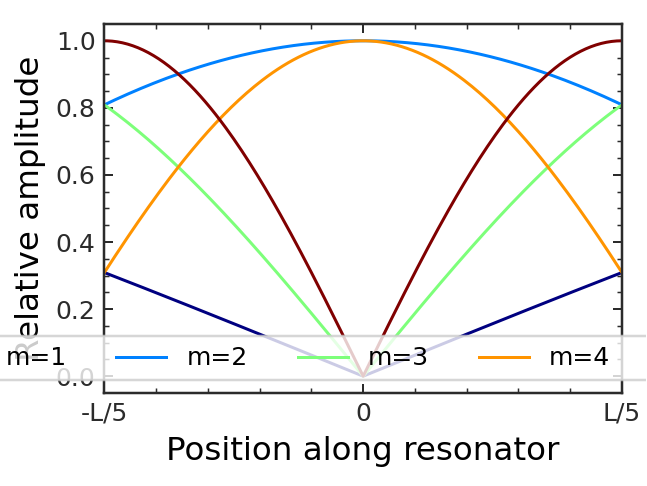

In [17]:
L = 1140
qubit_positions = [1/2 + 69.5/L]
N = [1, 2, 3, 
     4, 5
    ]


def resonator_voltage_scaling(x: float, mode: int):
    "x is in units between 0 and 1"
    return np.abs(np.cos(mode * np.pi * x))


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
cm = plt.cm.jet(np.linspace(0, 1, 5))
x = np.linspace(0, 1, 1001)

# Plot voltage modes
for idx, n in enumerate(N):
    ax.plot(x, resonator_voltage_scaling(x, n),
            color=cm[idx], label=f"m={n}")

# Plot qubit positions
# for q in qubit_positions:
#     ax.vlines(q, 0, 1, color="red", linestyles='--',
#               label=f"{1140*q}$\mu{{m}}$")


ax.set_xlabel("Position along resonator")
ax.set_ylabel("Relative amplitude")
plt.tight_layout()

ax.legend(ncol=5)
ax.set_xlim([0.4, 0.6])
ax.set_xticks([0.4, 0.5, 0.6])
ax.set_xticklabels(["-L/5", "0", "L/5"])
plt.savefig("./output/cqps/resonator-narrow.svg")

# ax.set_xlim([0, 1])
# ax.set_xticks([0, 0.5, 1])
# ax.set_xticklabels(["-L/2", "0", "L/2"])
# plt.savefig("./output/cqps/resonator-wide.svg")

## Resonator Fitting

In [110]:
def fano_model(omega, 
               omega0,
               A,
               B,
               q, 
               gamma
              ):
    _var = 2 * (omega - omega0) / gamma
    return A + B * (q + _var)**2 / (1 + _var**2)

<IPython.core.display.Javascript object>


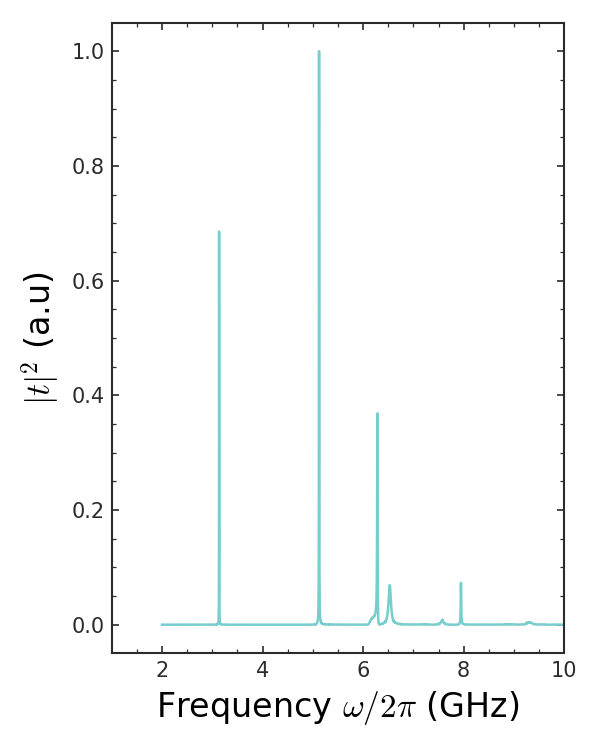

In [112]:
FILENAME="./data/2020-07_cqps-single/resonators/TiN95_CQPS_C_July12'20_res_01.txt"

data = np.loadtxt(FILENAME, skiprows=1)
data_x = data[:,0]/GHz
data_y = np.power((data[:,1]/max(data[:,1])), 2)
                       
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.plot(data_x, data_y/max(data_y), color="C4")

ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
ax.set_ylabel("$|t|^2$ (a.u)", size=16)
ax.set_xlim([1,10])
plt.tight_layout()
plt.savefig("./data/2020-07_cqps-single/resonators/full.svg")

### m2

[3.13674913e+00 1.12905571e+03 1.97715889e+00 1.01109372e+00]


<IPython.core.display.Javascript object>


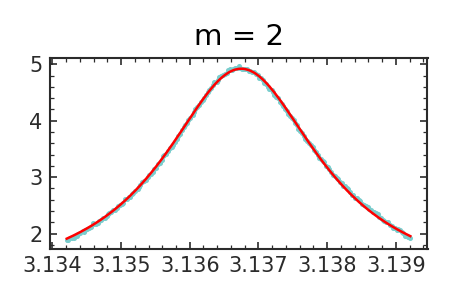

In [20]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/2020-07_cqps-single/resonators/m2.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]/GHz
Mag = data[:, 1]

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [3.1368, 1511, 9,1]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
print(popt)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq, Mag, marker="o", s=2, label='Data', color="C4")
ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit
ax.set_title("m = 2")

# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=18)
# ax.set_xlim([1,10])
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

### m3

[ 5.12093712e+09  1.51763601e+00 -1.37522019e+00 -3.01265847e-03
 -7.99910582e+06]


<IPython.core.display.Javascript object>


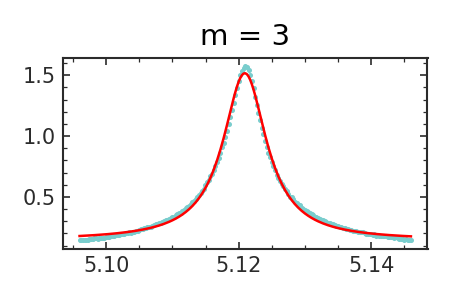

In [23]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/2020-07_cqps-single/resonators/m3.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.121, 640, 1.17,0]
# Fit the data, does not work
# popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
popt, pcov = curve_fit(fano_model, freq, Mag, p0 = [
    5.12*GHz, 
    1, 
    0.4, 
    0, 
    2*MHz])
# Results
print(popt)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq/GHz, Mag, marker="o", s=2, label='Data', color="C4")
ax.plot(freq/GHz, fano_model(freq, *popt),'r',label='Fit') #plot fit
ax.set_title("m = 3")

# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=16)
# ax.set_xlim([5.1,5.14])
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

### m4

[ 6.28468633e+09  2.96301996e+00 -2.12296409e+00 -1.62057014e-01
 -1.14146473e+07]
-11.41464727787845


<IPython.core.display.Javascript object>


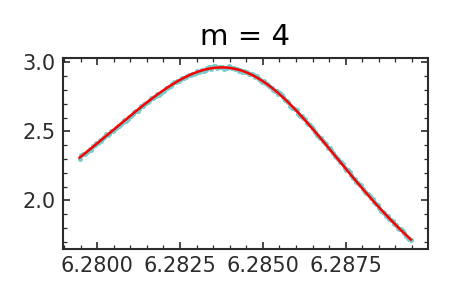

In [25]:

FILENAME="./data/2020-07_cqps-single/resonators/m4.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [6.284, 1129, 2,0]
# Fit the data, does not work
# popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
popt, pcov = curve_fit(fano_model, freq, Mag, p0 = [
    6.28*GHz, 
    1, 
    0.4, 
    0, 
    1*MHz])
# Results
print(popt)

print(popt[-1]/MHz)


fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq/GHz, Mag, marker="o", s=2, label='Data', color="C4")
# ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit
ax.plot(freq/GHz, fano_model(freq, *popt),'r',label='Fit') #plot fit

ax.set_title("m = 4")
# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=16)
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

### m5

[7.94606750e+09 2.99036905e-01 2.13847959e-04 6.87031131e+01
 1.43029156e+07]


<IPython.core.display.Javascript object>


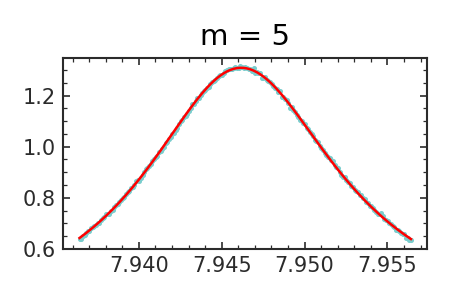

14.3029156448318


In [27]:
FILENAME="./data/2020-07_cqps-single/resonators/m5.txt"

data = np.loadtxt(FILENAME, skiprows=1)
freq = data[:, 0]
Mag = data[:, 1]

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [6.284, 1129, 2,0]
# Fit the data, does not work
# popt, pcov = curve_fit(_S21, freq[30:-30], Mag[30:-30], p0 = pguess, method='lm')
popt, pcov = curve_fit(fano_model, freq, Mag, p0 = [
    7.94*GHz, 
    1, 
    0.4, 
    0, 
    1*MHz])
# Results
print(popt)


fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(freq/GHz, Mag, marker="o", s=2, label='Data', color="C4")
# ax.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='Fit') #plot fit
ax.plot(freq/GHz, fano_model(freq, *popt),'r',label='Fit') #plot fit
ax.set_title("m = 5")
print(popt[-1]/MHz)

# ax.set_xlabel("Frequency $\omega/2\pi$ (GHz)", size=16)
# ax.set_ylabel("$|t|^2$ (a.u)", size=16)
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", ".svg"))

### Original fitting

fr = 3.1367491265796184 GHz
Ql = 1129.055709943327
A = 1.9771588878632131
c = 1.0110937206136499
kappa/(2 pi) = 2.7782058041556406 MHz


<IPython.core.display.Javascript object>


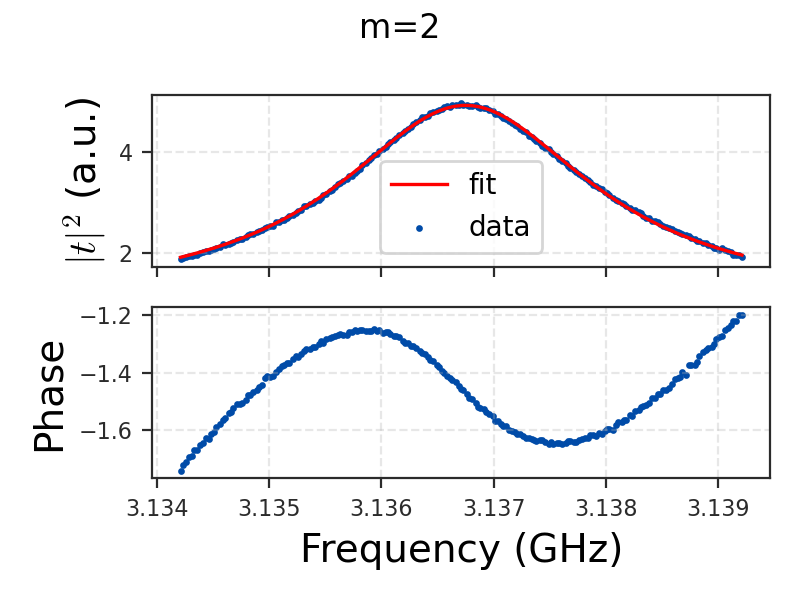

In [80]:
## Fitting resonator modes
## Raw data files: res01, cell Ay

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Second resonator mode
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m2')
m2 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [3.1368, 1511, 9,1] #fr (GHz), Ql, A, c (Offset) 
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
#print(popt)
print('fr = ' +str(popt[0])+' GHz')
print('Ql = ' +str(popt[1]))
print('A = ' +str(popt[2]))
print('c = ' +str(popt[3]))

kappa = popt[0]*1e9/popt[1]*1e-6 #MHz fn/Q
print('kappa/(2 pi) = ' +str(kappa)+' MHz')


# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=2')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, myfit(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()


fr = 5.124449415583922 GHz
Ql = 827.0903213748282
A = 1.970982386480035
c = 1.0838152768335418
kappa/(2 pi) = 6.195755509586695 MHz


<IPython.core.display.Javascript object>


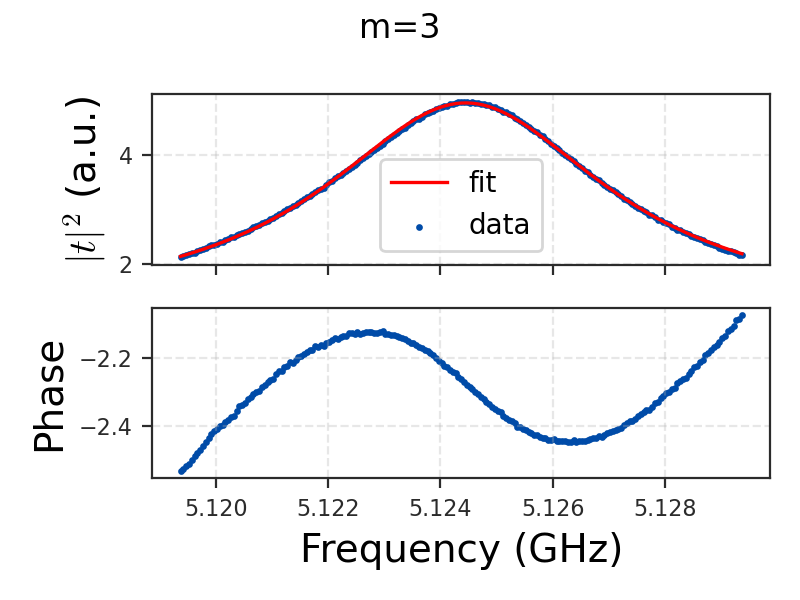

In [81]:
## Fitting resonator modes
## Raw data files: res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Third resonator mode, m=3
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m3')
m3 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.124, 1129, 2,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
#print(popt)
print('fr = ' +str(popt[0])+' GHz')
print('Ql = ' +str(popt[1]))
print('A = ' +str(popt[2]))
print('c = ' +str(popt[3]))

kappa = popt[0]*1e9/popt[1]*1e-6 #MHz, kappa/2pi = fn/Q
print('kappa/(2 pi) = ' +str(kappa)+' MHz')

# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=3')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

fr = 6.283513034105836 GHz
Ql = 400.3843641735347
A = 1.8549497707416605
c = -0.4860380814429356
kappa/(2 pi) = 15.693702342937732 MHz


<IPython.core.display.Javascript object>


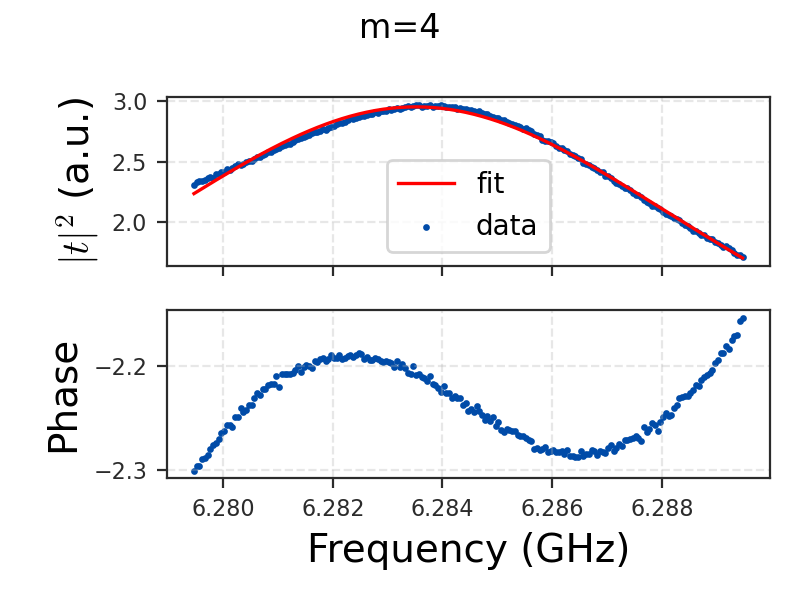

In [82]:
## Fitting resonator modes
## Raw data files: res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Fourth resonator mode, m=4
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m4')
m4 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [6.284, 1129, 2,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
#print(popt)
print('fr = ' +str(popt[0])+' GHz')
print('Ql = ' +str(popt[1]))
print('A = ' +str(popt[2]))
print('c = ' +str(popt[3]))

kappa = popt[0]*1e9/popt[1]*1e-6 #MHz fn/Q
print('kappa/(2 pi) = ' +str(kappa)+' MHz')

# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=4')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

fr = 7.9462332517509955 GHz
Ql = 556.75423911974
A = 1.0034805179010344
c = 0.30176333558158597
kappa/(2 pi) = 14.272425234362725 MHz


<IPython.core.display.Javascript object>


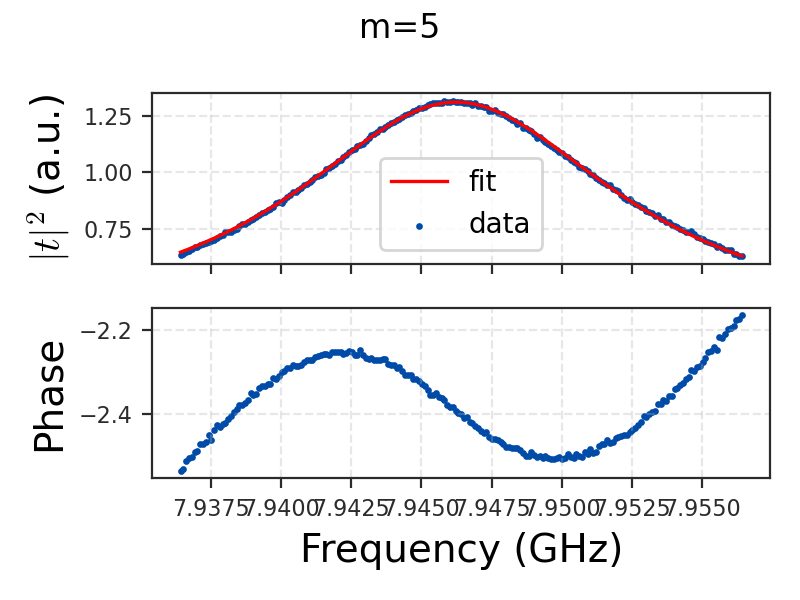

In [83]:
## Fitting resonator modes
## Raw data files: res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Fifth resonator mode, m=5
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m5')
m5 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [7.95, 900, 2,0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
#print(popt)
print('fr = ' +str(popt[0])+' GHz')
print('Ql = ' +str(popt[1]))
print('A = ' +str(popt[2]))
print('c = ' +str(popt[3]))

kappa = popt[0]*1e9/popt[1]*1e-6 #MHz fn/Q
print('kappa/(2 pi) = ' +str(kappa)+' MHz')

# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=5')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

fr = 5.120913957738829 GHz
Ql = 640.0454800135293
A = 1.1726744330709975
c = 0.14236244567057912
kappa/(2 pi) = 8.00085949771973 MHz


<IPython.core.display.Javascript object>


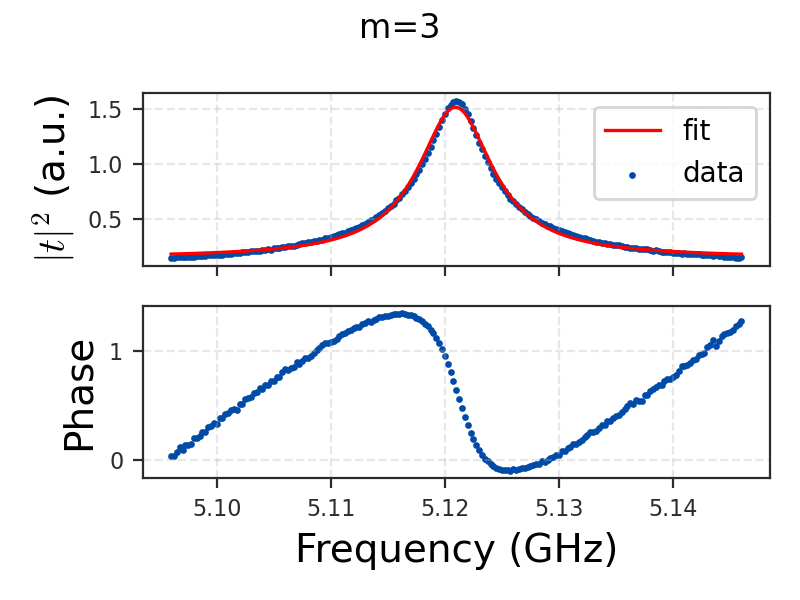

In [86]:
## Fitting resonator modes
## Raw data files: Ay cell, res01

FILENAME="./data/CQPS paper/data for article/TiN95_CQPS_C_July12'20_res_01.xlsx"

## Third resonator mode? but at higher power? Power used was -15dB
# Load data
import pandas as pd
df = pd.read_excel (FILENAME, sheet_name='m6')
m3 = pd.DataFrame(df, columns=['Frequency','r','e'])
freq = df['Frequency']*10**-9 #in GHz
Mag = df['r'] #r
Phase = df['e'] #e

## Lorentzian fit to obtain loaded Quality factor, Q_l

import scipy as sp
from scipy.optimize import curve_fit 

def _S21(f,fr,Ql,A,c):
       return A**2/(1.+4.*Ql**2*((f-fr)/fr)**2)+c
# Initial guess of the parameters (you must find them some way!)
pguess = [5.12444942, 827.09032137,   1.9,   0]
# Fit the data, does not work
popt, pcov = curve_fit(_S21, freq, Mag, p0 = pguess, method='lm')
# Results
#print(popt)
print('fr = ' +str(popt[0])+' GHz')
print('Ql = ' +str(popt[1]))
print('A = ' +str(popt[2]))
print('c = ' +str(popt[3]))

kappa = popt[0]*1e9/popt[1]*1e-6 #MHz fn/Q
print('kappa/(2 pi) = ' +str(kappa)+' MHz')

# Plot data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 3))
fig.suptitle('m=3')
ax1.scatter(freq, Mag, marker="o", s=2, label='data')
#ax1.plot(freq, _S21(freq, pguess[0], pguess[1], pguess[2], pguess[3]),'g',label='intial guess') #plot initial guess
ax1.plot(freq,_S21(freq, popt[0], popt[1], popt[2], popt[3]),'r',label='fit') #plot fit
ax1.legend()
ax1.legend()
#ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel("$|t|^2 $ (a.u.)")
ax2.scatter(freq, Phase, marker="o", s=2)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("Phase")
plt.tight_layout()

# (Code) Fitting of qubit spectrum
First we evalaute the transition energies of the cqps system
\begin{equation}
\mathcal{H} = E_L(\hat{n} - f)^2 - \frac{E_s}{2}\bigg[\left|n+1\right\rangle{\left\langle{n}\right|} + \left|n\right\rangle{\left\langle{n+1}\right|}\bigg],
\end{equation}

(It is very similar to the transmon Hamiltonian)
\begin{equation}
    \mathcal{H} = E_C{\left(\hat{N}-N_\text{ext}\right)^2}- \frac{E_J}{2}\bigg(\left|n+1\right\rangle{\left\langle n\right|}+\left|n\right\rangle{\left\langle n+1\right|}\bigg)
\end{equation}
    
I will simply use the transmon Hamiltonian to evaluate energies

<IPython.core.display.Javascript object>


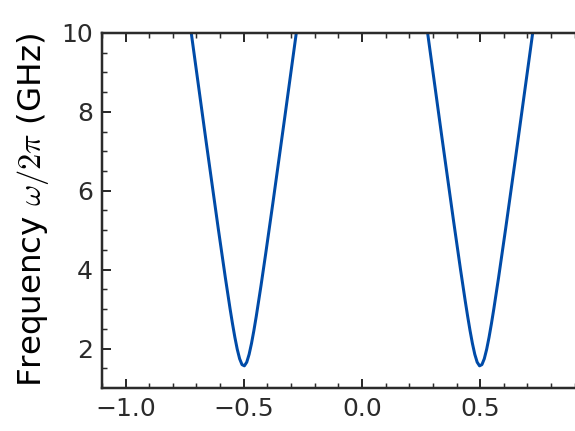

In [55]:
# Here we create the object with which we simulate cqps energies (very simple Hamiltonian). This is reused in all further cells
SIMULATION_PARAMETERS = {
    "number_of_states": 13,
    "number_of_levels_to_simulate": 2
}
QUBIT_PARAMETERS = {
    # We will override them in subsequent evaluations
    "ES": 10,
    "inductive_loop_squares": 30, # 30 140x140nm squares
     **SIMULATION_PARAMETERS
}
cqps_qubit = QuantumBuilder.build_cqps_qubit(
    QUBIT_PARAMETERS, logging_level=logging.ERROR,
)

# Example invocation
FLUX_NUMBER = np.linspace(-1, 1, 200)
EL = 22.2
ES = 1.56
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([1,10])
plt.tight_layout()

<IPython.core.display.Javascript object>


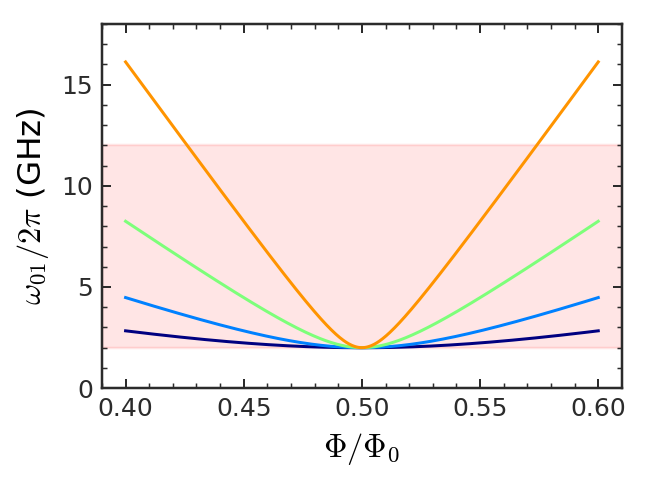

In [18]:
# Here we create the object with which we simulate cqps energies (very simple Hamiltonian). This is reused in all further cells
SIMULATION_PARAMETERS = {
    "number_of_states": 13,
    "number_of_levels_to_simulate": 2
}
QUBIT_PARAMETERS = {
    # We will override them in subsequent evaluations
    "ES": 10,
    "inductive_loop_squares": 30, # 30 140x140nm squares
     **SIMULATION_PARAMETERS
}
cqps_qubit = QuantumBuilder.build_cqps_qubit(
    QUBIT_PARAMETERS, logging_level=logging.ERROR,
)

# Example invocation
FLUX_NUMBER = np.linspace(0.4, 0.6, 500)
EL_list = [10, 20, 40, 80]
ES = 2
f01_list = []
COLORMAP_12 = plt.get_cmap('jet')

for EL in EL_list:
    cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
    simulation = cqps_qubit.run_simulation(
        FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
    qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
    f01_list.append(qubit_f01)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhspan(2, 12, color='red', alpha=0.1)

for i, qubit_f01 in enumerate(f01_list):
    Ip = EL_list[i] * h *GHz / Phi0 / nA
    simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01, 
                                color=COLORMAP_12(i / len(EL_list)),
#                                 label=f"{Ip:.2f} nA"
                                    label=f"{EL_list[i]} GHz"
                               )

# ax.legend(title="$E_L$", ncol=4)
ax.set_xlabel("$\Phi/\Phi_0$")
ax.set_ylabel("$\omega_{01}/2\pi$ (GHz)")
ax.set_ylim([0,18])
plt.tight_layout()

# plt.savefig("./output/cqps-single-simulation-1.svg")
plt.savefig("./output/cqps-single-simulation-2.svg")
# plt.savefig("./output/cqps-single-simulation-3.svg")

# (Code) Next we introduce interaction with the resonator
*Note that below, definition of $g$ changes to $\hbar{g}$ and therefore it changes halfway*

*Hamitlonian at this stage*

\begin{equation}
 \frac{1}{\hbar}H_{qubit-resonator} = \frac{\omega_{q}}{2}\sigma_z + \omega_r{a^{\dagger}}a + g(a^{\dagger} + a)\sigma_x
\end{equation}

In the truncated matrix form between states $\left|e, N\right\rangle$ and $\left|g, N+1\right\rangle$
\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\omega_q}{2} + (N)\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\omega_q}{2} + (N+1)\omega_r
  \end{pmatrix}
\end{equation}

We introduce the detuning factor $\delta =\omega_{q} - \omega_{r}$ in order to write out

\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\delta}{2} + (N+\frac{1}{2})\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\delta}{2} + (N+\frac{1}{2})\omega_r
  \end{pmatrix}
\end{equation}

which reads as
\begin{equation}
  \begin{aligned}
      &= {\hbar\omega_r(N+\frac{1}{2})\mathbb{I} +\frac{ \hbar\delta}{2}\sigma_z} + {\hbar g_0\sqrt{N+1}\sigma_x}\\
      & = {\hbar\omega_r(N+\frac{1}{2})\mathbb{I}} + \frac{1}{2}\sqrt{(\hbar\delta)^2 + 4\hbar^2g_0^2(N+1)} \bigg(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x\bigg)\\
      & = \hbar\omega_r(N+\frac{1}{2})\mathbb{I} + E_{\text{coupled}}(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x)\\
      & \text{where } E_\text{coupled} = \frac{\hbar}{2}\sqrt{\delta^2 + 4g_0^2(N+1)};\qquad \tan(\theta) = \frac{g_0\sqrt{N+1}}{\delta/2}.
  \end{aligned}
\end{equation}

and thus, like in the paper after doing the torating frame

\begin{equation}
\frac{E}{\hbar} = \left( n + \frac{1}{2} \right)\omega_{r} + \frac{\omega_q}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^2 + g_0^2(N+1)}
\end{equation}

At `N = 0`

\begin{equation}
 \frac{E}{\hbar} = \frac{\omega_{r}}{2} + \frac{\omega_{q}}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^{2} + g^2}
\end{equation}

**Any measurement on the VNA is actually $X/2\pi$ i.e. we are fitting $g/2\pi$ to the experimental results and not just $g$**

<IPython.core.display.Javascript object>


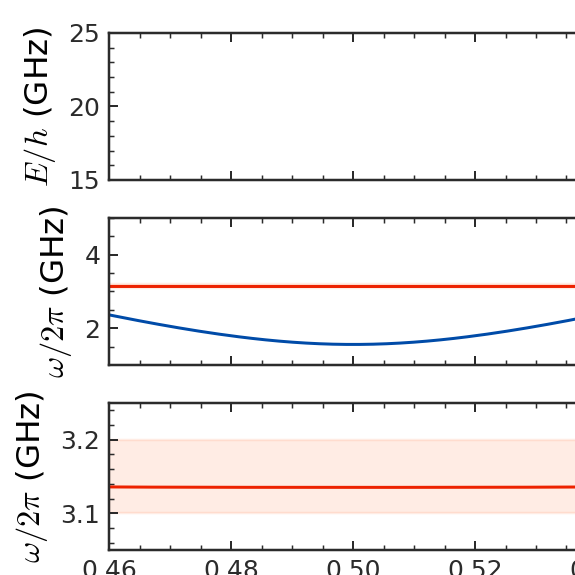

In [389]:
def qubit_resonator_spectrum(qubit_f01: list, resonator_f: float, g: float, N:int=0):
    """
    Everything in MHz or everything in GHz. 
    
    @param g will be g/2pi - so if using it later on, don't forgot about this!
    """
    e_high = []
    e_low = []
    for dQubit in qubit_f01:
        a = dQubit / 2
        b = resonator_f * (N + 1/2)
        c = (dQubit - resonator_f) / 2

        factor = np.sqrt(c**2 + g**2*(N+1))
        e_high.append(a+b+factor)
        e_low.append(a+b-factor)
        
    return (e_low, e_high)

# Example invocation
g = 29.9 * (MHz/GHz) # Everything is done in GHz, but MHz is the natural scale
resonator_f = 3.13461
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g, N=0)

# fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# qubit_graph, = ax.plot(FLUX_NUMBER, qubit_f01)

fig, ax_arr = plt.subplots(3, 1, figsize=(4, 4), sharex=True)
ax = ax_arr[0]
ax.plot(FLUX_NUMBER, simulation["eigvals"][:, 0], color="C0")
ax.plot(FLUX_NUMBER, simulation["eigvals"][:, 0] + e_low, color="C4")
ax.plot(FLUX_NUMBER, simulation["eigvals"][:, 0] + e_high, color="C3")
ax.set_ylabel("$E/h$ (GHz)")
ax.set_ylim([15,25])
# ax.plot(FLUX_NUMBER, simulation["eigvals"][:, 0] + resonator_f)

ax = ax_arr[1]
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, "C0")
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, "C1")
ax.axhspan(3.2,3.1,color="C6", alpha = 0.2)
ax.set_ylim([1,5])
ax.set_ylabel("$\omega/2\pi$ (GHz)")

ax = ax_arr[2]
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, "C0")
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, "C1")
ax.axhspan(3.2,3.1,color="C6", alpha = 0.2)
ax.set_ylim([3.05,3.25])
ax.set_ylabel("$\omega/2\pi$ (GHz)")

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_xlim([0.46, 0.54])

plt.tight_layout()
plt.savefig("./output/cqps/cqps-resonator-anticrossing.svg")
# plt.savefig("./output/cqps/cqps-resonator-small.pdf")

# (Code) Master equations simulation

We are solving the master equation for the full system

 \begin{equation}
  \begin{aligned}
    \dot{\rho} = -\frac{i}{\hbar}\left[ \mathcal{H}, \rho \right] + \mathcal{L}\left[ \rho \right] & = i\frac{\delta_{q}}{2}\left[ \sigma_z\rho - \rho\sigma_z \right] -i\delta_{r}\left[ {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & - ig{\left[ a\sigma_+\rho - \rho{a}\sigma_+ + {a}^{\dagger}\sigma_{-}\rho - \rho{a}^{\dagger}\sigma_{-} \right]}\\
    & - i{\frac{\Omega}{2}}\left[ a\rho - \rho{a} + {a}^{\dagger}\rho - \rho{a}^{\dagger} \right]\\
    & + \frac{\kappa}{2}\left[ 2a\rho{a}^{\dagger} - {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & + \frac{\Gamma_{1}}{2}\left[ 2\sigma_{-}\rho\sigma_{+} - \sigma_+\sigma_{-}\rho - \rho\sigma_+\sigma_{-} \right]\\
    & + \frac{\Gamma_{\phi}}{2}\left[ \sigma_z\rho\sigma_z - \rho \right]
  \end{aligned}
 \end{equation}


## Representation in 2 qubit - 2 resonator basis (N=0, N=1)

We will use the truncated subspace of vectors in the following $\left|e, n\right\rangle, \left|e, n+1\right\rangle, \left|g, n\right\rangle, \left|g, n+1\right\rangle$ with $n=0$

The representation of operator $\hat{A}$ in this subspace will be
\begin{equation}
 \begin{pmatrix}
   \left\langle e, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
 \end{pmatrix}
\end{equation}

In [11]:
NR = 2
OFFSET = 0

qubit_ket = qt.basis(2,0)
resonator_ket = qt.basis(NR, 0)
example_state = qt.tensor(
    [
        qt.ket2dm(qubit_ket), 
        qt.ket2dm(resonator_ket)
    ])
example_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  \sigma_z =
  \begin{pmatrix}
    1 & . & . & . \\
    . & 1 & . & . \\
    . & . & -1 & .\\
    . & . & . & -1
  \end{pmatrix}
\end{equation}

In [12]:
op_sigmaz = qt.tensor(
    qt.sigmaz(),
    qt.identity(NR)
)
op_sigmaz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

\begin{equation}
  a=
  \begin{pmatrix}
    . & \sqrt{n+1} & . & . \\
    . & .& .& .\\
    . & . & . & \sqrt{n+1} \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [13]:
op_a = qt.tensor(
    qt.identity(2),
    qt.destroy(NR, offset=OFFSET)
)
op_a

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}=
  \begin{pmatrix}
    . & . & . & . \\
    \sqrt{n} & .& .& .\\
    . & . & . & . \\
    . & . & \sqrt{n} & .
  \end{pmatrix}
\end{equation}


In [14]:
op_adagger = qt.tensor(
    qt.identity(2),
    qt.create(NR, offset=OFFSET)
)
op_adagger

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]

\begin{equation}
  \sigma_{-} =
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    1 & . & . & . \\
    . & 1 & . & .
  \end{pmatrix}
\end{equation}

In [15]:
op_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.identity(NR)
)
op_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

\begin{equation}
  \sigma_{+} =
  \begin{pmatrix}
    . & . & 1 & . \\
    . & . & . & 1 \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [16]:
op_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.identity(NR)
)
op_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}a =
  \begin{pmatrix}
    n & . & . & . \\
    . & n+1 & . & . \\
    . & . & n & . \\
    . & . & . & n+1
  \end{pmatrix}
\end{equation}

In [17]:
op_n = qt.tensor(
    qt.identity(2),
    qt.num(NR, offset=OFFSET)
)
op_n

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

\begin{equation}
  a\sigma_{+}=
  \begin{pmatrix}
    . & . & . & \sqrt{n+1} \\
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}


In [18]:
op_a_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.destroy(NR, offset=OFFSET)
)
op_a_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}\sigma_-=
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & . \\
    \sqrt{n+1} & . & . & .
  \end{pmatrix}
\end{equation}

In [19]:
op_adagger_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.create(NR, offset=OFFSET)
)
op_adagger_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]

## Analytical solution from mathematica
- Using **very** inefficient methods (manual substitution, since Mathematica chockes when told to solve for the 4x4 equations), we have found an analytical solution in the case of weak drive
- $\Omega << 1$ and therefore $\mathcal{O(\Omega^2)}$  terms were set to 0

- The expectation values:

\begin{equation}
  \begin{aligned}
 \left\langle a \right\rangle & = -i{\frac{\Omega/2}{\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}+i\delta_q} + \left( \frac{\kappa}{2}+i\delta_r \right)}}\\
    &={\frac{\Omega/2}{\frac{g^{2}}{\delta_{q}-i{\left( \frac{\Gamma_{1}}{2}+\Gamma_{\phi} \right)}} - (\delta_r - i\frac{\kappa}{2})}}\\
  \end{aligned}
\end{equation}
\begin{equation}
  \begin{aligned}
     \left\langle a^\dagger \right\rangle &= i{\frac{\Omega/2}{\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}-i\delta_q} + \left( \frac{\kappa}{2}-i\delta_r \right)}}\\
     &={\frac{\Omega/2}{\frac{g^{2}}{\delta_{q}+i{\left( \frac{\Gamma_{1}}{2}+\Gamma_{\phi} \right)}} - (\delta_r + i\frac{\kappa}{2})}}\\
  \end{aligned}
\end{equation}

- Solutions give the field in the resonator at the output line  and thus the voltage in the resonator
\begin{equation}
 V_r{\left( \left\langle a \right\rangle + \left\langle a^{\dagger} \right\rangle  \right)}
\end{equation}
This field induces a displacement current across capacitance $C_k$ through which the resonator couples to the output line $V_{resonator}/Z_{gap} = V_{resonator} / \frac{1}{i\omega{C_k}}$ which generates a voltage output line with impedance Z
\begin{equation}
 V_{out}(t) \approx V_r{\left( \left\langle a^{\dagger} \right\rangle + \left\langle a \right\rangle  \right)} \left[ -i\omega{C_{k}} \right]Z
\end{equation}

- Subbing in the values will give
\begin{equation}
\begin{aligned}
V_{out}(t) & = -i\omega{C_{k}}Z V_r \left[\frac{\Omega/2}{g^2/\delta_q' - \delta_r'}+cc\right]\\
& = -i\omega{C_{k}}Z V_r \frac{\Omega}{2}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\omega{C_{k}}Z V_r \left[\frac{C_{k}V_{in}V_r}{\hbar}\frac{1}{2}\right]\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\omega{C_k^2Z}V_{in} \left[ \frac{1}{\hbar}\frac{1}{2} \right] \frac{\hbar\omega}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
 & = -i\frac{1}{2}V_{in}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+ cc\right]\\
\end{aligned}
\end{equation}

where:
- $\delta_{q}'=\delta_{q} + i\left( \frac{\Gamma_1}{2}+\Gamma_{\phi} \right)$
- $\delta_{r}'=\delta_{r} +i\frac{\kappa}{2}$

Then a simple ratio gives the transmission coefficient:
\begin{equation}
 t = \frac{V_{out}}{V_{in}} = -i\frac{1}{2}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'} + cc\right]
\end{equation}

Since experiment is done with $f$ instead of $\omega$, then:
- $\delta_q$ and $\delta_r$ will actually be $\delta_q/2\pi$ and $\delta_r/2\pi$
- $g$ will also be $g/2\pi$

**Therefore - we continue to work with units of $g/2\pi, \Gamma/2\pi,\kappa/2\pi$**

This means that the bracket section will need a prefactor of $\frac{1}{2\pi}$ (expanded in mathematica)
\begin{equation}
\frac{1}{2\pi}\frac{2 g^2 \delta _q-2 \delta _q^2 \delta _r-2 \Gamma ^2 \delta _r}{\left(\Gamma  \kappa '+g^2\right)^2-2 g^2 \delta _q \delta _r+\delta _q^2 \left(\left(\kappa '\right)^2+\delta _r^2\right)+\Gamma ^2 \delta _r^2}
\end{equation}

Furtheremore, we need to take the absolute value by taking the modulus

<IPython.core.display.Javascript object>


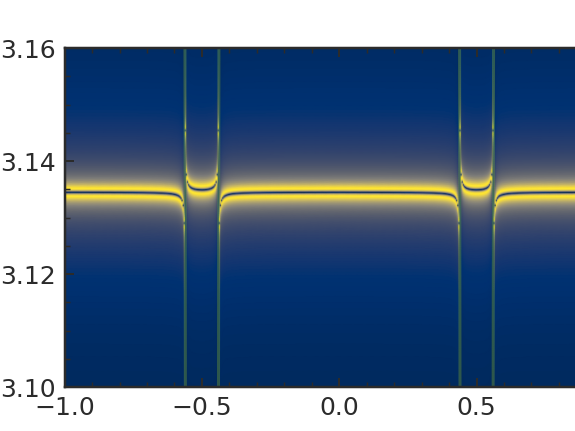

(3.1, 3.16)

In [376]:
def make_transmission_function(Gamma1: float, GammaPhi:float, kappa: float, g: float):
    """
    Function defined within a function, so that it has seeded parameters to evalute transmission(deltaQ, deltaR)
    
    - See mathematica notebook for how this expansion was found.
    - Γ/2pi, g/2pi, kappa/2pi
    - Make sure everything is in MHz
    @returns The bracket section (see above) in MHz units
    """
    Gamma = Gamma1/2 + GammaPhi
    kappaPrime = kappa / 2
    twoGSquared = 2*g**2
    twoGammaSquared = 2*Gamma**2
    GammaSquared=Gamma**2
    gSquaredPlusGammaKappaPrimed_allSquared = (g**2 + Gamma*kappaPrime)**2
    kappaPrimeSquared = kappaPrime**2
    
    def transmission(delta_q: float, delta_r: float) -> float:
        delta_qSquared = delta_q**2
        delta_rSquared = delta_r**2
        
        # We are interested in the amplitude, so take the square
        return np.abs(
            (twoGSquared*delta_q - twoGammaSquared*delta_r - 2*delta_qSquared*delta_r)
            / 
            (- twoGSquared*delta_q*delta_r 
             + GammaSquared*delta_rSquared 
             + gSquaredPlusGammaKappaPrimed_allSquared 
             + delta_qSquared*(delta_rSquared + kappaPrimeSquared))
        ) / TWOPI
    # Return in in MHz units
    return transmission

# Example application
Gamma1 = 0.26 # MHz
GammaPhi = 0 # MHz
kappa = 1.39 # MHz
g = 25 # MHz

resonator_f = 3.13461
sweep_f = np.linspace(3.1, 3.16, 501)

# Simulate qubit
FLUX_NUMBER = np.linspace(-1, 1, 501)
EL = 22.2
ES = 1.56
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Construct a matrix of detunings. We step along the magnetic field (changing the freqyency of the qubit) and 
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000 #to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

# Simulate qubit-resonator
tGrid = make_transmission_function(Gamma1, GammaPhi, kappa, g)(deltaQ, deltaR)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

# Plot
fig, ax_arr = plt.subplots(1, 1, figsize=(4, 3))
ax = ax_arr
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tGrid), 
              shading='gouraud', 
            cmap=plt.cm.cividis);
ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"], alpha=0.3)

ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([sweep_f[0], sweep_f[-1]])

# ax = ax_arr[1]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"], alpha=0.3)
# ax.set_ylim([sweep_f[0], sweep_f[-1]])
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# plt.tight_layout()

# (Calibration - must run) Data Analysis and Calibration

- [x] Capacitance of the coupling resoantor-transmission line by fitting the master equation (fitting amplitude of transmission and extracting $C_k$)

Teresa
- [x] Sending of EL values for the qubits in paper
- [x] Try to get $C_{rt}$ and $C_r$ from geometrical simulations

## Evaluating $C_{resonator}$
$f = \frac{v_{ph}}{2L} = \frac{1}{2L\sqrt{cl}} \Rightarrow c=\frac{1}{4L^2 f^2 l}$

where L is the length of resonator, $c, l$ are the capacitances and inductance per unit length respectively.

- Below we take the fits of persistent current in loop $I_p$ and evaluate the inductance in the loop: $L = \frac{\Phi_0}{I_p}$
- Then we normalise by the number of squares forming the loop, to get inductance per square

| Qubit | Ip (nA) | L(nH)     | Loop number of squares | L (nH) per 1.4µm x 1.4µm square |           |
|-------|---------|-----------|------------------------|---------------------------------|-----------|
| 1     | 8.69    | 238.20483 | 35.535714              | 7.5534941                       |           |
| 2     | 7.37    | 280.86839 | 37.214286              | 7.5473271                       |           |
| 3     | 8.07    | 256.50558 | 37.75                  | 6.7948498                       |           |
| 4     | 6.64    | 311.74699 | 39.357143              | 7.9209761                       |           |
| 5     | 7.99    | 259.07384 | 39.821429              | 6.5058901                       |           |
| 6     | 7.9     | 262.02532 | 40.464286              | 6.4754712                       |           |
| 9     | 7.68    | 269.53125 | 43.892857              | 6.1406632                       |           |
| 12    | 7.04    | 294.03409 | 44.857143              | 6.5549001                       | 6.9912388 |
|       |         |           |                        |                                 | average   |

And compare to expected value:
\begin{equation}
  L_{k,\square} = \frac{\hbar{R_\square}}{\pi{\color{red}{\Delta(B)}}}
 \end{equation}

In [117]:
L_expected = hbar * 2.*kOhm/(np.pi*1.738*1.7*kb)
L_expected

1.6500251128555198e-09

In [383]:
# We need to be very careful with the units that we are using
# Below we work out the values for the resonator
unit_square = 5*um
L_per_unit_square = 7*nH
L_per_unit_length = L_per_unit_square/unit_square

resonator_length = 1150*um
f_resonator = 1.57*GHz
C_per_unit_length = 1/(4 * f_resonator**2 * resonator_length**2 * L_per_unit_length)

C_resonator = C_per_unit_length * resonator_length
print(f"Resonator capacitance = {C_resonator/fF:.2f}fF")
print(f"Resonator inductance = {L_per_unit_length * resonator_length/nH:.2f}nH")
print(f"Z = {np.sqrt(L_per_unit_length/C_per_unit_length)}")

Resonator capacitance = 63.00fF
Resonator inductance = 1610.00nH
Z = 5055.4000000000015


## Checking values of g
\begin{equation}
 g = \frac{\pi{E_s}}{2e}C_{q-r}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

We got values of $g$ of 34, 20 and 44 MHz

In [384]:
ES = 1.56
V_qubit = np.pi * ES / 2 / e
V_qubit

1.531526418625024e+19

In [386]:
C_per_unit_length

5.477936422346793e-11

In [385]:
C_qr = C_per_unit_length * 10*um
C_qr

5.477936422346793e-16

In [121]:
resonator_f = 3.14*GHz
V_resonator = np.sqrt(h * resonator_f / C_resonator)
V_resonator

5.752961263711064e-06

In [122]:
V_qubit * C_qr * V_resonator * 1000 # To convert to GHz

# This is the right order to magnitude, indicating correct assesment of C_total and C_per_unit_length

48.26506884555401

## Checking coupling capacitance $C_k$
- Oelsner: $\kappa \approx \frac{2ZC_{k}^{2}\omega^{2}}{C_r}$
- Astafiev lectures: $\kappa = \Delta\omega = \frac{\omega(2\omega ZC_k)^2}{\pi}$
$\kappa = \Delta{\omega} = \frac{\alpha^2\omega}{\pi{n}} = \frac{\omega(2\omega{Z}C_k)^2}{\pi{n}} = \frac{2f(2\omega{Z}C_k)^2}{n} = \frac{v}{2L}\frac{2(2\omega{Z}C_k)^2}{n} = \frac{1}{\sqrt{lc}2L}\sqrt{\frac{l}{c}}\frac{2Z(2\omega{C}_k)^2}{n} = \frac{1}{c2L}\frac{2Z(2\omega{C}_k)^2}{n} = \frac{1}{2C_{resonator}}\frac{2Z(2\omega{C}_k)^2}{n} = \frac{4Z\omega^2{C}_k^2}{nC_r}$

The calculations below using fitted values of $\kappa$, estimated values for the resonator capacitance $C_total$ and driving frequency gives the coupling capacitance of $C_k \approx 2\times10^{-15}fF$

24.159748839113853

<IPython.core.display.Javascript object>


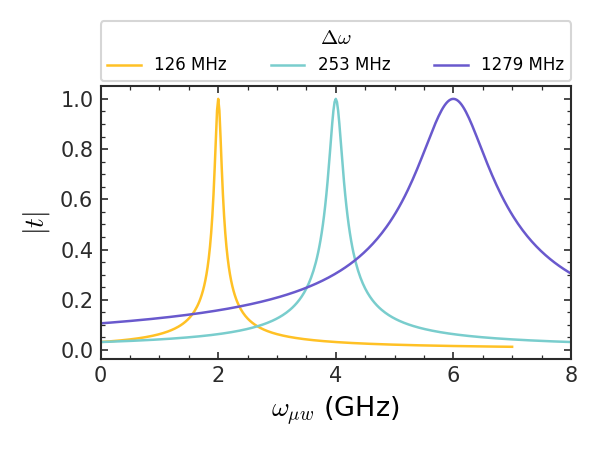

In [215]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# work in MHz
def resonator(w, deltaOmega):
    return 1 / np.sqrt(1 + np.power(2*w/deltaOmega,2))

def deltaOmega(fc, C_rt, Z, Cr):
    wc = TWOPI*fc
    return (
        4 * Z * wc**2 * C_rt**2 / Cr
    )

dw = np.linspace(-5000, 5000,501)*MHz
fc = 2*GHz
C_rt = 2*fF
Z = 5000
Cr = 100*fF

width = deltaOmega(fc, C_rt, Z, Cr)
# print(width)
# print(TWOPI**3*fc*(2*fc*Z*C_rt)**2/np.pi)
ax.plot(dw/GHz + fc/GHz, resonator(dw, width), color="C3", label=f"{width/MHz:.0f} MHz")

dw = np.linspace(-5000, 5000,501)*MHz
fc = 4*GHz
Cr = 200*fF
width = deltaOmega(fc, C_rt, Z, Cr)
ax.plot(dw/GHz + fc/GHz, resonator(dw, width), color="C4", label=f"{width/MHz:.0f} MHz")

dw = np.linspace(-8000, 5000,501)*MHz
fc = 6*GHz
C_rt = 3*fF
width = deltaOmega(fc, C_rt, Z, Cr)
ax.plot(dw/GHz + fc/GHz, resonator(dw, width), color="C5", label=f"{width/MHz:.0f} MHz")
ax.set_xlim([0,8])
ax.set_ylabel("$|t|$")
ax.set_xlabel("$\omega_{\mu{w}}$ (GHz)")
ax.legend(title="$\Delta\omega$",bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, fontsize=8)

plt.tight_layout()
plt.savefig("./output/resonator-linewidth.pdf")

In [123]:
# Consistent value using Oelsner expression
kappa = 2.78*MHz
Z = 50
omega_drive = resonator_f*GHz * 2*np.pi

C_k = np.sqrt(kappa * C_resonator / (2 * Z))/omega_drive
C_k

2.1211446963929414e-24

In [124]:
# Consistent value using Astafiev expression
kappa = 2.78*MHz
Z = 50
omega_drive = resonator_f*GHz * 2*np.pi

C_k = np.sqrt(2 * kappa * C_resonator / (4 * Z * omega_drive**2))
C_k

2.1211446963929418e-24

# (Figure 4 + Figure 5) Qubit 12 Analysis
- Ay cell

In [52]:
# Global parameters
PERIOD = 0.1818 # Should not be changed
OFFSET = 0.1836 - PERIOD/2

## Qubit spectrum

In [474]:
FILENAME="./data/2020-07_cqps-single/two-tone/TiN95_CQPS_C_July12'20_two_tone_3G_102_data-phase.txt"


#Magnetic field constant
mf_c = 1.52 #G/mA

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1]) * mf_c
#     data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
    
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


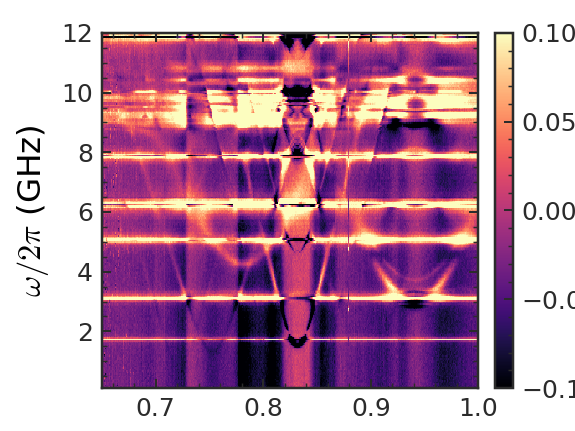

In [229]:
PERIOD1 = 0.4275 #mA
PERIOD3 = 0.33 #mA, ?
# PERIOD4 =  #mA
PERIOD9 = 0.20694 #mA
# PERIOD12 =  #mA

FLUX_NUMBER = np.linspace(0, 1, 200)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Qubit 6
# (PERIOD, OFFSET) = (0.2487, 0.53)
# EL = 24
# ES = 1
# cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
# simulation = cqps_qubit.run_simulation(
#     FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
# qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
# simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C2")

# QUbit 5
# (PERIOD, OFFSET) = (0.2685, 0.55)
# EL = 23.9
# ES = 1.3
# cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
# simulation = cqps_qubit.run_simulation(
#     FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
# qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
# simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C2")

# Qubit 4
# (PERIOD, OFFSET) = (0.2817, 0.57)
# EL = 21.3
# ES = 4.3
# cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
# simulation = cqps_qubit.run_simulation(
#     FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
# qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
# simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C2")

# Qubit 2
# (PERIOD, OFFSET) = (0.3487, 0.68)
# EL = 24
# ES = 3
# cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
# simulation = cqps_qubit.run_simulation(
#     FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
# qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
# simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C2")

# Qubit 12
# (PERIOD, OFFSET) = (0.1818, 0.695)
# EL = 22.2
# ES = 1.56
# cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
# simulation = cqps_qubit.run_simulation(
#     FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
# qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
# simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C2")

im = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.magma,
              rasterized=True,
              vmax=0.1,
              vmin=-0.1
             )

ax.set_xlabel("$B_\mathrm{ext} (G)$")
ax.set_ylabel("$\omega/2\pi$ (GHz)")
ax.set_ylim([0.1, 12])
ax.set_xlim([0.65, 1])
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="arg($t$)"
# orientation="horizontal"
                 )
# ax.set_xlim([0.65, 1])
plt.tight_layout()

In [205]:
def update(ES: float, EL: float, toggle: bool, offset):    
#     cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)

#     simulation = cqps_qubit.run_simulation(
#         FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
#     qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

#     simulation_graph.set_ydata(qubit_f01)
    simulation_graph.set_xdata(FLUX_NUMBER * PERIOD * mf_c + offset)
    simulation_graph.set_visible(toggle)
    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()
    
ES_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$ES (GHZ)$", value=ES,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
EL_widget = ipywidgets.FloatSlider(
    min=0, max=30, step=0.1,
    description="$EL (GHz)$", value=EL,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)
offset_widget = ipywidgets.FloatSlider(
    min=0, max=1, step=0.01,
    description="Offset", value=OFFSET,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)

ui = ipywidgets.GridspecLayout(4, 1)
ui[0,0] = ES_widget
ui[1,0] = EL_widget
ui[2,0] = toggle_widget
ui[3,0] = offset_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "ES": ES_widget,
        "EL": EL_widget,
        "toggle": toggle_widget,
        "offset": offset_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=4.3, description='$ES (GHZ)$', layout=Layout(grid_area='widget001',…

Output()

In [230]:
plt.savefig(FILENAME.replace("txt","svg"))

<IPython.core.display.Javascript object>


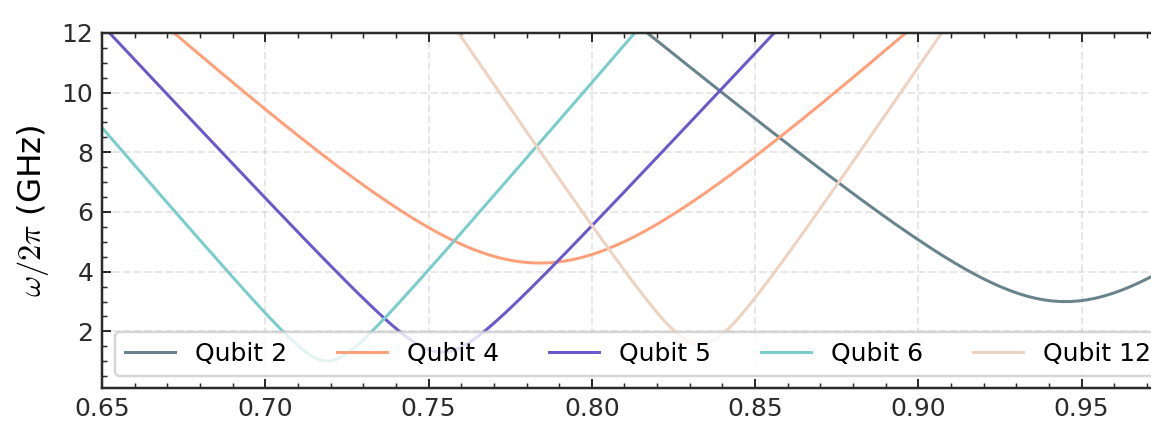

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

# Qubit 2
(PERIOD, OFFSET) = (0.3487, 0.68)
EL = 24
ES = 3
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C7", label="Qubit 2")

# Qubit 4
(PERIOD, OFFSET) = (0.2817, 0.57)
EL = 21.3
ES = 4.3
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C6", label="Qubit 4")

# QUbit 5
(PERIOD, OFFSET) = (0.2685, 0.55)
EL = 23.9
ES = 1.3
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C5", label="Qubit 5")

# Qubit 6
(PERIOD, OFFSET) = (0.2487, 0.53)
EL = 24
ES = 1
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C4", label="Qubit 6")

# Qubit 12
(PERIOD, OFFSET) = (0.1818, 0.695)
EL = 22.2
ES = 1.56
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
simulation_graph, = ax.plot(FLUX_NUMBER * PERIOD * mf_c + OFFSET, qubit_f01, color="C8", label="Qubit 12")

ax.set_xlabel("$B_\mathrm{ext} (G)$")
ax.set_ylabel("$\omega/2\pi$ (GHz)")
ax.set_ylim([0.1, 12])
ax.set_xlim([0.65, 1])
plt.legend(ncol=5)
plt.tight_layout()
plt.grid()
plt.savefig(FILENAME.replace(".txt", "-sim.svg"))

### Linewidth

  \begin{equation}
    L(x)      =      L_0\frac{1}{\pi}\frac{\frac{1}{2}\xi}{\big(\frac{1}{2}\xi\big)^2+(x-x_0)^2} = \frac{2L_0}{\pi\xi}\frac{1}{1 + (\frac{2dx}{\xi})^2}\quad\quad
    V_\text{max} =  \frac{2}{\pi\xi}L_0 = \frac{2L_0T}{\pi} \quad\quad\text{FWHM}  = \xi \text{(x-scale)} \equiv \frac{2\pi}{T}
    \text{($ \omega $-scale)}
  \end{equation}

[1.26947330e-03 1.38323833e-02 1.52724498e+00 9.93405756e-01]
Gamma/2pi = 13.832383348752703 -> Gamma = 86.91142782015855


<IPython.core.display.Javascript object>


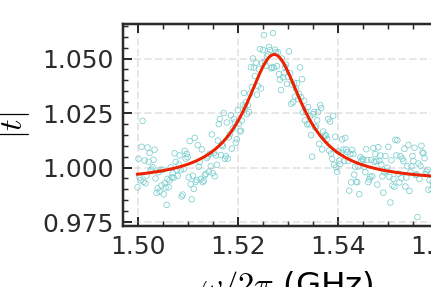

In [231]:
FILENAME = "./data/2020-07_cqps-single/two-tone/TiN95_CQPS_C_July12'20_two_tone_3G_Q12_HD_91_data.txt"
from scipy.optimize import curve_fit 

data = np.loadtxt(FILENAME, skiprows=1)
data_x = data[:, 0][:300]
data_y = data[:, 1][:300]

def lorentzian(x, A, width, center, offset):
    width_over_2 = width/2
    return A / np.pi * width_over_2 / (width_over_2**2 + (x-center)**2) + offset

popt, _ = curve_fit(
    lorentzian, 
    data_x, 
    data_y,
    p0 = [
        0.06,
        0.025,
        1.525,
        1
    ]
)
print(popt)
print(f"Gamma/2pi = {popt[1]*1000} -> Gamma = {popt[1]*1000*2*np.pi}")


fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(data_x, data_y, s=5, facecolors='none', edgecolors='C4', linewidth=0.3)
ax.plot(data_x, lorentzian(data_x, *popt), color="C1")

# ax.plot(field, response,
#         linestyle="", markersize=3,
#         marker="o", color="orange")
# ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
#               shading='nearest',
#               cmap=plt.cm.ocean)
ax.set_xlabel("$\omega/2\pi$ (GHz)")
ax.set_ylabel("$|t|$")
# ax.set_ylim([1, 8])
# ax.set_xlim([1, 5])
plt.tight_layout()
plt.grid()

plt.savefig(FILENAME.replace(".txt", ".svg"))

## Anticrossing on m=2
- g = 34MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth
- Resonator parameters taken from Teresa's fittings

In [23]:
FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
if os.getenv('ILYAS_SIMULATIONS'):
    FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
    
OFFSET = 1.4566 - PERIOD/2

resonator_f = 3.13461 #GHz
kappa = 2.78 #MHz

# These are in MHz
g = 29.9
Gamma1 = 20
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


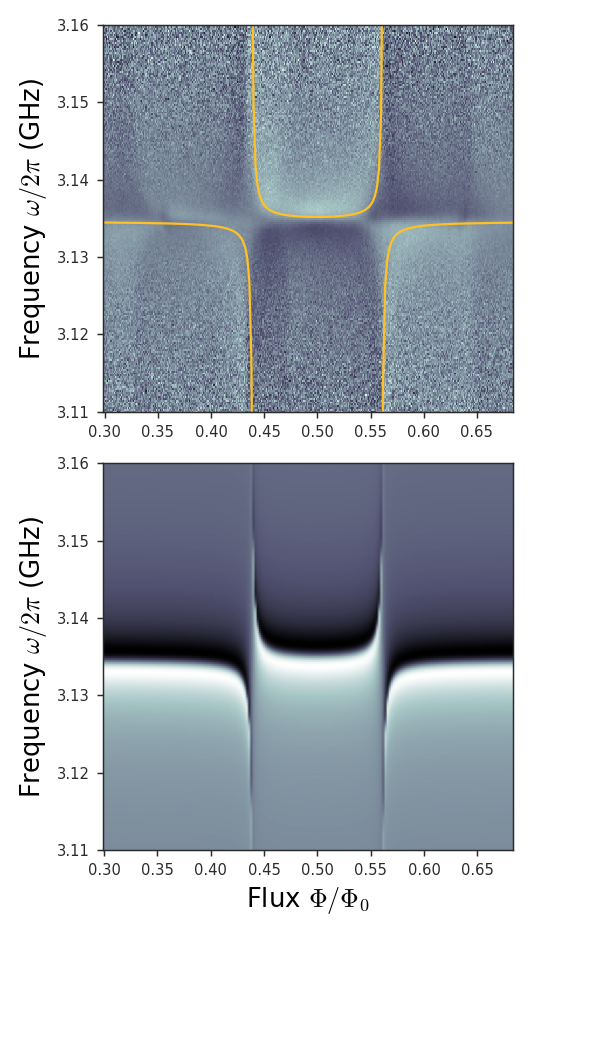

In [13]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [99]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)
    #e_low_plot_LARGE.set_ydata(e_low)
    #e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=3.13461, continuous_update=False, description='$f_r (GHz)$', layout…

Output()

In [22]:
plt.savefig(FILENAME.replace("txt","pdf"),dpi=100)

## Anticrossing on m=3
- g = 20MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [8]:
FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
if os.getenv('ILYAS_SIMULATIONS'):
    FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
OFFSET = 1.4566 - PERIOD/2

resonator_f = 5.12 #GHz
kappa = 6.2 *#MHz

# These are in MHz
g = 20
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


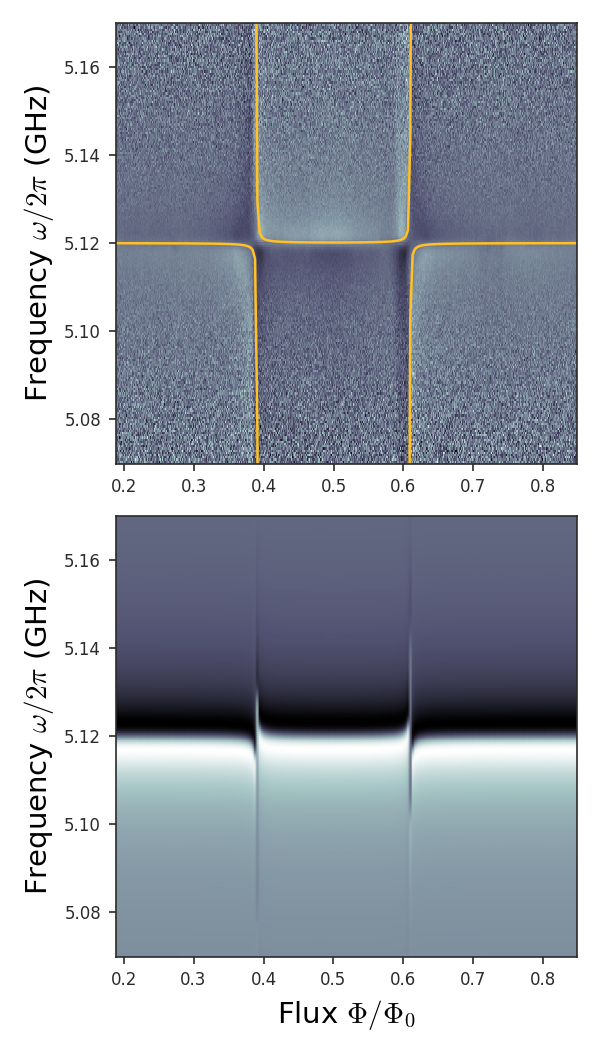

In [9]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [106]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    #e_low_plot_LARGE.set_ydata(e_low)
    #e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=5.12, continuous_update=False, description='$f_r (GHz)$', layout=La…

Output()

In [27]:
plt.savefig(FILENAME.replace("txt","pdf"),dpi=100)

## Anticrossing on m=4
- $g$ hard to define
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [16]:
FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-6_3G_m15dBm_43_data.txt"
if os.getenv('ILYAS_SIMULATIONS'):
    FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-6_3G_m15dBm_43_data.txt"
OFFSET = 0.1836 - PERIOD/2

resonator_f = 6.28143 #GHz
kappa = 8.5 #MHz
#kappa = 15.7 #MHz

# These are in MHz
g = 20
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


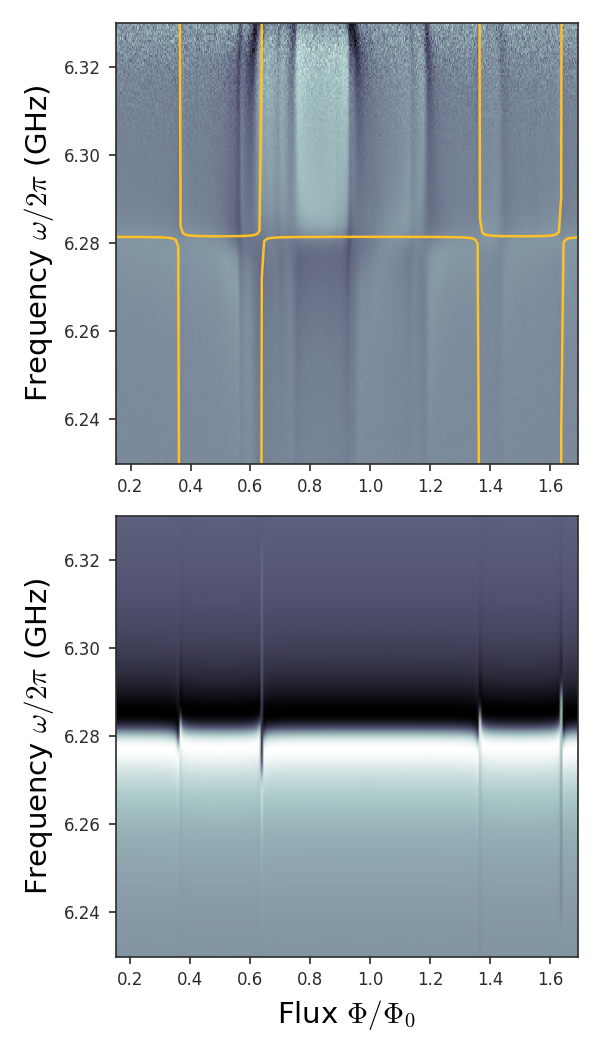

In [17]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [112]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    #e_low_plot_LARGE.set_ydata(e_low)
    #e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=6.28143, continuous_update=False, description='$f_r (GHz)$', layout…

Output()

## Anticrossing on m=5
- g = 44MHz
- $\Gamma$ effects the "sharpness" of the up/down cliffs. Very on the eye - we should probably fit it from the qubit linewidth

In [18]:
FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"
if os.getenv('ILYAS_SIMULATIONS'):
    FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"

OFFSET = 0.1836 - PERIOD/2

resonator_f = 7.9395 #GHz
#kappa = 11.1 #MHz
kappa = 14.27 #MHz

# These are in MHz
g = 44
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], 200)
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

0


<IPython.core.display.Javascript object>


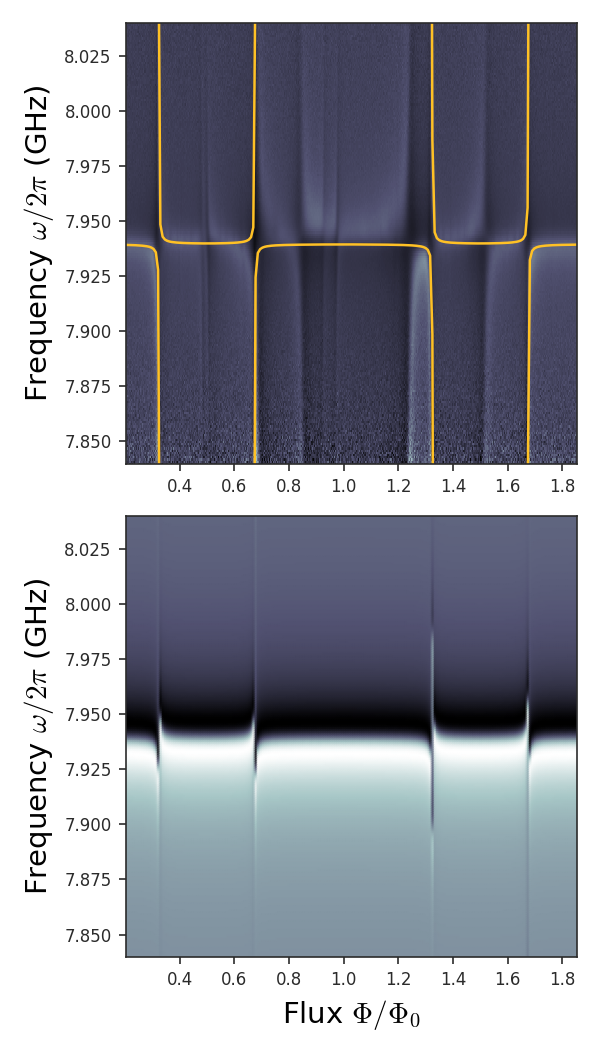

In [19]:
# Qubit
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Resonator-qubit
(e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f,
                                           g/1000  # convert to GHz
                                           )

# For master equation simulation
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ)*1000  # to convert from GHz to MHz
deltaR = np.array(deltaR)*1000

transmission_function = make_transmission_function(
    Gamma1, GammaPhi, kappa, g)
tMesh = transmission_function(deltaQ, deltaR)

# Plot
fig, ax_arr = plt.subplots(2, 1, figsize=(4, 7))
ax = ax_arr[0]
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.bone)
e_low_plot, = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"])
e_high_plot, = ax.plot(FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"])
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([data3d_y[0], data3d_y[-1]])

ax = ax_arr[1]
ax.pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")

# ax = ax_arr[2]
# ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"],
#         linestyle="-", linewidth=6, alpha=0.5, label="Qubit Spectrum")
# e_low_plot_LARGE, = ax.plot(FLUX_NUMBER, e_low,
#                             color=MY_COLOURS["Orange"])
# e_high_plot_LARGE, = ax.plot(FLUX_NUMBER, e_high,
#                              color=MY_COLOURS["Orange"],
#                              label="Qubit-Resonator"
#                              )
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
# ax.legend()

plt.tight_layout()

In [117]:
def update(g: float, resonator_f: float, Gamma: float, kappa: float, toggle: bool):
    # Pass in g in MHz
    (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, 
                                               resonator_f, 
                                               g/1000)
    e_low_plot.set_ydata(e_low)
    e_high_plot.set_ydata(e_high)    
    #e_low_plot_LARGE.set_ydata(e_low)
    #e_high_plot_LARGE.set_ydata(e_high)
    
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)        

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = transmission_function(deltaQ, deltaR)
    ax_arr[1].clear()
    ax_arr[1].pcolormesh(deltaXMesh, deltaYMesh, np.transpose(tMesh), 
              shading='gouraud', 
            cmap=plt.cm.bone)
CONTINOUS_UPDATE = False    
g_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.05,
    description="$g/2\pi (MHz)$", value=g,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
resonator_widget = ipywidgets.FloatSlider(
    min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
    description="$f_r (GHz)$", value=resonator_f,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
Gamma_widget = ipywidgets.FloatSlider(
    min=0, max=200, step=0.1,
    description="$\Gamma (MHz)$", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
kappa_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.1,
    description="$\kappa (MHz)$", value=kappa,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Show/Hide Fit',
    value=True
)

ui = ipywidgets.GridspecLayout(4, 2)
ui[0,:] = resonator_widget
ui[1,:] = g_widget
ui[2,0] = Gamma_widget
ui[2,1] = kappa_widget
ui[3,:] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget, "resonator_f": resonator_widget, "toggle": toggle_widget,
        "Gamma": Gamma_widget, "kappa": kappa_widget
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=7.9395, continuous_update=False, description='$f_r (GHz)$', layout=…

Output()

## Anticrossing summary
We have
\begin{equation}
 {\hbar}g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

- $L=1140$
- $x = L/2 + 69.5$
- $f_{fundametal}=3.13461\text{GHz}/2$

In experiment, we actually measure $g/2\pi$ and therefore we divide by $h$ instead of $\hbar$

All are off by a factor of 1.2 to 1.5 (likely we understimated the coupling capcitance), but qualitative tendency is captured

In [116]:
# Since finger is narrower, we use a different capacitance per unit length to the resonator - it is higher
Cqr = 3*um * 10**(-10)
f_fundametal = 3.13461/2 *GHz
L = 1140 #µm

# Derived
V_resonator = np.sqrt(h * f_fundametal / C_resonator)

NameError: name 'C_resonator' is not defined

In [114]:
# Qubit 3
qubit_position = 1/2 + 15/L
ES = 0.98

# Derived
V_qubit = 2 * np.pi * ES*GHz*h / 2 / e

def expected(m):
    return (
        1 / 2
        * V_qubit
        * V_resonator
        * np.sqrt(m)
        * np.abs(np.cos(m * np.pi * qubit_position))
    ) / h / MHz * Cqr

g_solutions = {
    2: 15,
    3: 7,
    4: 25
}
for k, v in g_solutions.items():
    print(f"{k} | {expected(k):<20} | {v:<20} {v / expected(k)}")

NameError: name 'V_resonator' is not defined

In [115]:
# Qubit 5
ES = 1.3
qubit_position = 1/2 + 35/L

# Derived
V_qubit = 2* np.pi * ES*GHz*h / 2 / e

def expected(m):
    return (
        1 / 2
        * V_qubit
        * V_resonator
        * np.sqrt(m)
        * np.abs(np.cos(m * np.pi * qubit_position))
    ) / h / MHz * Cqr

g_solutions = {
    2: 17,
    3: 6.5
}
for k, v in g_solutions.items():
    print(f"{k} | {expected(k):<20} | {v:<20} {v / expected(k)}")

NameError: name 'V_resonator' is not defined

In [303]:
# Qubit 6
ES = 1
qubit_position = 1/2 + 59/L

# Derived
V_qubit = 2* np.pi * ES*GHz*h / 2 / e

def expected(m):
    return (
        1 / 2
        * V_qubit
        * V_resonator
        * np.sqrt(m)
        * np.abs(np.cos(m * np.pi * qubit_position))
    ) / h / MHz * Cqr

g_solutions = {
    2: 13,
    3: 6.5
}
for k, v in g_solutions.items():
    print(f"{k} | {expected(k):<20} | {v:<20} {v / expected(k)}")

2 | 16.042096814367955   | 13                   0.8103678808593568
3 | 9.717248800408402    | 6.5                  0.6689136126397025


In [305]:
# Qubit 12
ES = 1.56
qubit_position = 1/2 + 69.5/L

# Derived
V_qubit = 2 * np.pi * ES*GHz*h / 2 / e

def expected(m):
    return (
        1 / 2
        * V_qubit
        * V_resonator
        * np.sqrt(m)
        * np.abs(np.cos(m * np.pi * qubit_position))
    ) / h / MHz * Cqr

g_solutions = {
    2: 25,
    3: 10,
    4: 25,
    5: 44
}
for k, v in g_solutions.items():
    print(f"{k} | {expected(k):<20} | {v:<20} {v / expected(k)}")

2 | 24.495762372121188   | 25                   1.0205846880868132
3 | 17.57906051801387    | 10                   0.5688586139033229
4 | 26.91425162343704    | 25                   0.9288759111633592
5 | 34.15062003185571    | 44                   1.288409989597752


# (Figure 4+5) Fitting anticrossing transmission amplitudes
I will be doing this by fitting the amplitude of the anticrossing fits (which we simulate with the master equation)

- qubit 12 in cell TY
- need to take into account the attenuation and amplification in the cell for the transmission
- All units related the the transmission amplitude **must** be done in MHz - this is the way we have defined the formulas earlier in the notebook
- All units relatex to the spectrum (energies) **must** be done in GHz

In [574]:
# Global parameters
PERIOD = 0.1818 # Should not be changed
OFFSET = 0.1836 - PERIOD/2

In [576]:
FILENAME="./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"
if os.getenv('ILYAS_SIMULATIONS'):
    FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-7_9G_m15dBm_38_data.txt"

resonator_f = 7.9395 #GHz
kappa = 14.27 #MHz
transmissionScalingPrefactor = kappa / 8

# There are in GHz
EL = 22.2
ES = 1.56

# These are in MHz
g = 34
Gamma1 = 22
GammaPhi = 0

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x - OFFSET) / PERIOD
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], len(data3d_x))
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], len(data3d_y))
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]
(e_low, e_high) = qubit_resonator_spectrum(
    qubit_f01, resonator_f, g / 1000  # convert to GHz
)

<IPython.core.display.Javascript object>


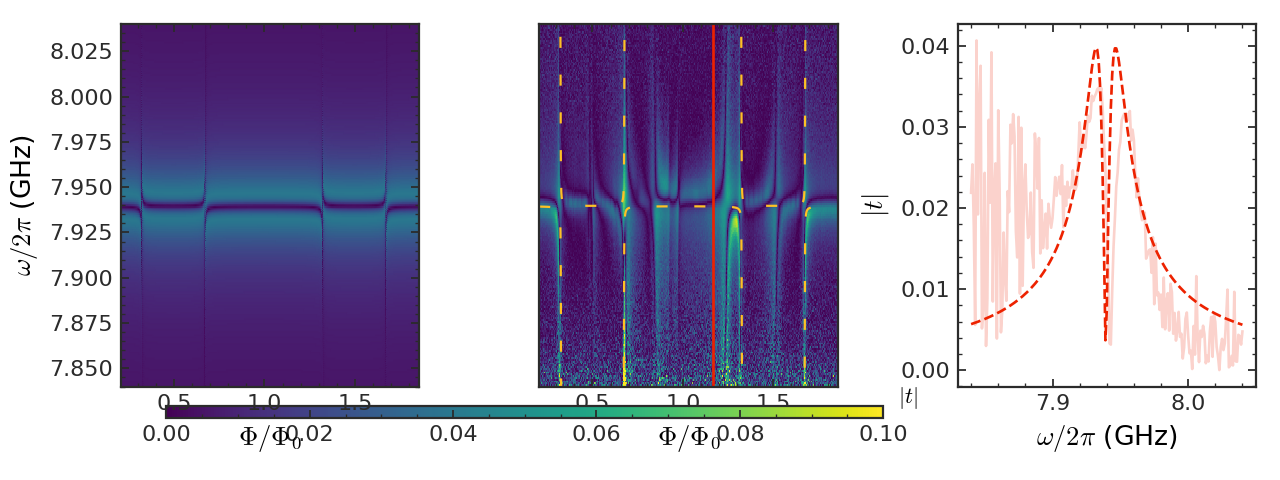

<ipython-input-602-92dabd8fa45e>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [602]:
SLICE_HORIZONTAL = 100
SLICE_VERTICAL = 3501
TRANSMISSION_MULTIPLIER =  (
    10 ** (
    (-30 - 40 -1 + 35 + 28 + 28) / 20
    )
)
TRANSMISSION_OFFSET = 0.105
DATA_CORRECTED = np.abs(data3d_z / TRANSMISSION_MULTIPLIER - TRANSMISSION_OFFSET)

# Master equation simulation (MHz)
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ) * 1000  # to convert from GHz to MHz
deltaR = np.array(deltaR) * 1000

transmission_function = make_transmission_function(Gamma, 0, kappa, g) 
tMesh = np.transpose(transmission_function(deltaQ, deltaR)) * transmissionScalingPrefactor

# Plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 3, 2)
im1 = ax.pcolormesh(data3d_xmesh, data3d_ymesh, DATA_CORRECTED, shading="nearest", 
                    vmax=0.1, vmin=0,
                    rasterized=True)
cbar_ax = fig.add_axes([0.13, 0.13, 0.56, 0.025])
cb = fig.colorbar(im1, cax=cbar_ax, orientation="horizontal")
cb.set_label("$|t|$", ha="left", x=1.02, fontsize=10, labelpad=-27)
ax.set_xlabel("$\Phi/\Phi_0$", fontsize=12)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
(e_low_plot,) = ax.plot(
    FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="--", linewidth=1, dashes=(5, 12)
)
(e_high_plot,) = ax.plot(
    FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="--", linewidth=1, dashes=(5, 12)
)

ax1 = fig.add_subplot(1, 3, 1)
im2 = ax1.pcolormesh(
    deltaXMesh, deltaYMesh, tMesh, shading="gouraud",
    vmax=0.1, vmin=0, 
    rasterized=True
)
ax1.set_xlabel("$\Phi/\Phi_0$", fontsize=12)
ax1.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=12)
ax.set_yticks([])
ax.set_yticklabels([])
ax.axvline(data3d_x[SLICE_VERTICAL], color="C1")
# ax.axhline(data3d_y[SLICE_HORIZONTAL], color=MY_COLOURS["DarkRed"])

ax2 = fig.add_subplot(1, 3, 3)
ax2.plot(
    data3d_y,
    DATA_CORRECTED[:, SLICE_VERTICAL],
#     np.abs((data3d_z[:, SLICE_VERTICAL])),
    color="C1",
    alpha=0.2,
#     facecolors='none', edgecolors='C4', linewidth=0.3
)
(slice_y_plot,) = ax2.plot(
    deltaYMesh[:, SLICE_VERTICAL],
    tMesh[:, SLICE_VERTICAL],
    color="C1",
    linestyle="--",
)
ax2.set_xlabel("$\omega/2\pi$ (GHz)", fontsize=12)
ax2.set_ylabel("$|t|$", fontsize=12)
plt.tight_layout()

In [603]:
plt.savefig(FILENAME.replace(".txt", ".svg"))

### m=2

In [462]:
FILENAME = "./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data.txt"
if os.getenv("ILYAS_SIMULATIONS"):
    FILENAME = "./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-3_13G_18_data-ilya-corrected.txt"
OFFSET = 1.4566 - PERIOD / 2

# Fixed and previously measured values
resonator_f = 3.13461  # GHz

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))

    first_line = fin.readline().split()
    data3d_x = np.linspace(
        float(first_line[1]), float(first_line[2]), data3d_z.shape[1]
    )
    data3d_x = (data3d_x - OFFSET) / PERIOD

    second_line = fin.readline().split()
    data3d_y = np.linspace(
        float(second_line[1]), float(second_line[2]), data3d_z.shape[0]
    )

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], len(data3d_x))
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], len(data3d_y))
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

# Qubit (GHz)
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"]
)
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

<IPython.core.display.Javascript object>


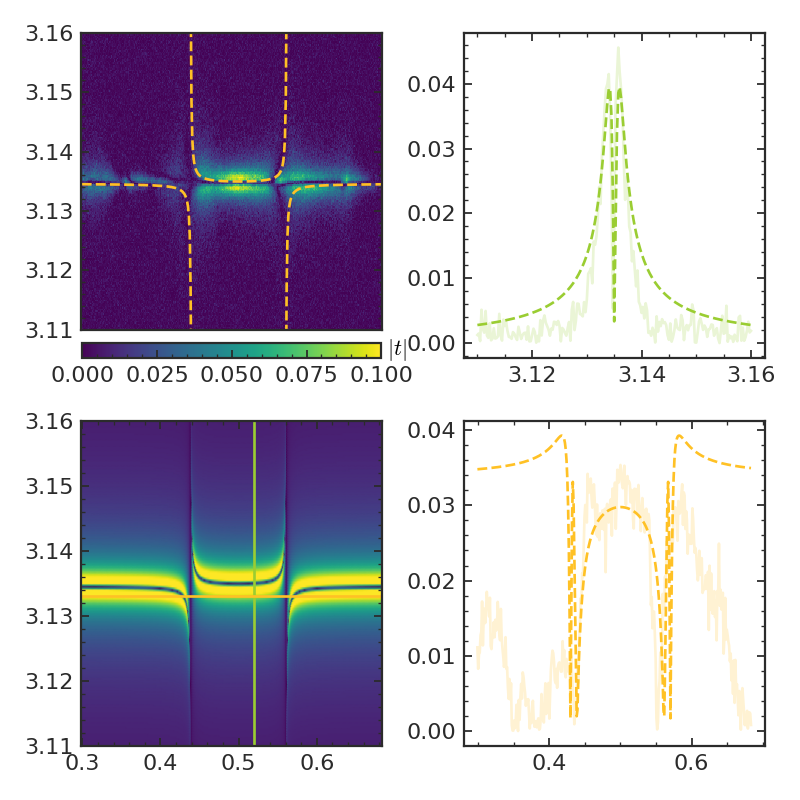

In [463]:
# Seed values. Remember - these are all g/2pi, Γ/2pi, k/2pi etc...
kappa = 1.78  # MHz fitted in resonator. kappa/2pi
omega_drive = resonator_f * GHz * 2 * np.pi
C_k = C_per_unit_length * 20 * um  # From dimensions of coupling capacitor
# transmissionScalingPrefactor = (
#     1 / 2 * (C_k**2 * omega_drive**2 * Z) / C_resonator / MHz
# )  # Needs to be in MHz, because make_transmission_function requires and returns a result in MHz units
transmissionScalingPrefactor = kappa / 8
g = 24
Gamma = 30

SLICE_HORIZONTAL = 92
SLICE_VERTICAL = 201

ADDITIONAL_ATTENUATION = 0
TRANSMISSION_MULTIPLIER = 10 ** (
    (-30 - 60 + 35 + 28 + 28 - ADDITIONAL_ATTENUATION) / 10
) * 1.4

# Resonator-qubit spectrum (GHz)
(e_low, e_high) = qubit_resonator_spectrum(
    qubit_f01, resonator_f, g / 1000  # convert to GHz
)
# Master equation simulation (MHz)
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ) * 1000  # to convert from GHz to MHz
deltaR = np.array(deltaR) * 1000

transmission_function = make_transmission_function(Gamma, 0, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))

fig = plt.figure(figsize=(5, 5))

# Plot of raw data and Jaynes Cummings overlay
ax = fig.add_subplot(2, 2, 1)
im = ax.pcolormesh(
    data3d_xmesh, data3d_ymesh, data3d_z, shading="nearest", vmax=0.1, vmin=0
)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, orientation="horizontal")
cb.set_label("$|t|$", ha="left", x=1.02, fontsize=10, labelpad=-22)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.set_xticks([])
ax.set_xticklabels([])
(e_low_plot,) = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="--")
(e_high_plot,) = ax.plot(
    FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="--"
)

# Plot of master equation simulation
ax1 = fig.add_subplot(2, 2, 3)
im1 = ax1.pcolormesh(deltaXMesh, deltaYMesh, tMesh, shading="gouraud", vmax=0.15, vmin=0)
ax1.axvline(data3d_x[SLICE_VERTICAL], color="C2")
ax1.axhline(data3d_y[SLICE_HORIZONTAL], color=MY_COLOURS["Orange"])

# Fitting cross section in field
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(
    data3d_y,
    (data3d_z[:, SLICE_VERTICAL]) / TRANSMISSION_MULTIPLIER,
    color="C2",
    alpha=0.2,
)
(slice_y_plot,) = ax2.plot(
    deltaYMesh[:, SLICE_VERTICAL],
    +transmissionScalingPrefactor * tMesh[:, SLICE_VERTICAL],
    color="C2",
    linestyle="--",
)

# Fitting cross section in frequency
ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(
    data3d_x,
    (data3d_z[SLICE_HORIZONTAL, :]) / TRANSMISSION_MULTIPLIER,
    color=MY_COLOURS["Orange"],
    alpha=0.2,
)
(slice_x_plot,) = ax3.plot(
    deltaXMesh[SLICE_HORIZONTAL, :],
    transmissionScalingPrefactor * tMesh[SLICE_HORIZONTAL, :],
    color=MY_COLOURS["Orange"],
    linestyle="--",
)
plt.tight_layout()

In [419]:
def update(g: float, Gamma: float, toggle: bool, kappa):
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)
    if toggle:
        (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g / 1000)
        e_low_plot.set_ydata(e_low)
        e_high_plot.set_ydata(e_high)

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = np.transpose(transmission_function(deltaQ, deltaR))
    ax1.clear()
    ax1.pcolormesh(deltaXMesh, deltaYMesh, tMesh, shading="gouraud")
    slice_y_plot.set_ydata(transmissionScalingPrefactor * tMesh[:, SLICE_VERTICAL])
    slice_x_plot.set_ydata(transmissionScalingPrefactor * tMesh[SLICE_HORIZONTAL, :])


CONTINOUS_UPDATE = False
g_widget = ipywidgets.FloatSlider(
    min=0,
    max=200,
    step=0.05,
    description="$g/2\pi (MHz)$",
    value=g,
    layout=ipywidgets.Layout(width="90%"),
    continuous_update=CONTINOUS_UPDATE,
)
# resonator_widget = ipywidgets.FloatSlider(
#     min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
#     description="$f_r (GHz)$", value=resonator_f,
#     layout=ipywidgets.Layout(width='90%'),
#     continuous_update=CONTINOUS_UPDATE
# )
Gamma_widget = ipywidgets.FloatSlider(
    min=0,
    max=200,
    step=0.1,
    description="$\Gamma/2\pi (MHz)$",
    value=Gamma1,
    layout=ipywidgets.Layout(width="90%"),
    continuous_update=CONTINOUS_UPDATE,
)
kappa_widget = ipywidgets.FloatSlider(
    min=0,
    max=20,
    step=0.1,
    description="$\kappa/2\pi (MHz)$",
    value=kappa,
    layout=ipywidgets.Layout(width="90%"),
    continuous_update=CONTINOUS_UPDATE,
)
toggle_widget = ipywidgets.Checkbox(description="Show/Hide Fit", value=True)

ui = ipywidgets.GridspecLayout(4, 2)
# ui[0,:] = resonator_widget
ui[0, :] = g_widget
ui[1, :] = Gamma_widget
ui[2, :] = kappa_widget
ui[3, :] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget,
        #         "resonator_f": resonator_widget,
        "toggle": toggle_widget,
        "Gamma": Gamma_widget,
        "kappa": kappa_widget,
    },
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=24.0, continuous_update=False, description='$g/2\\pi (MHz)$', layou…

Output()

<IPython.core.display.Javascript object>


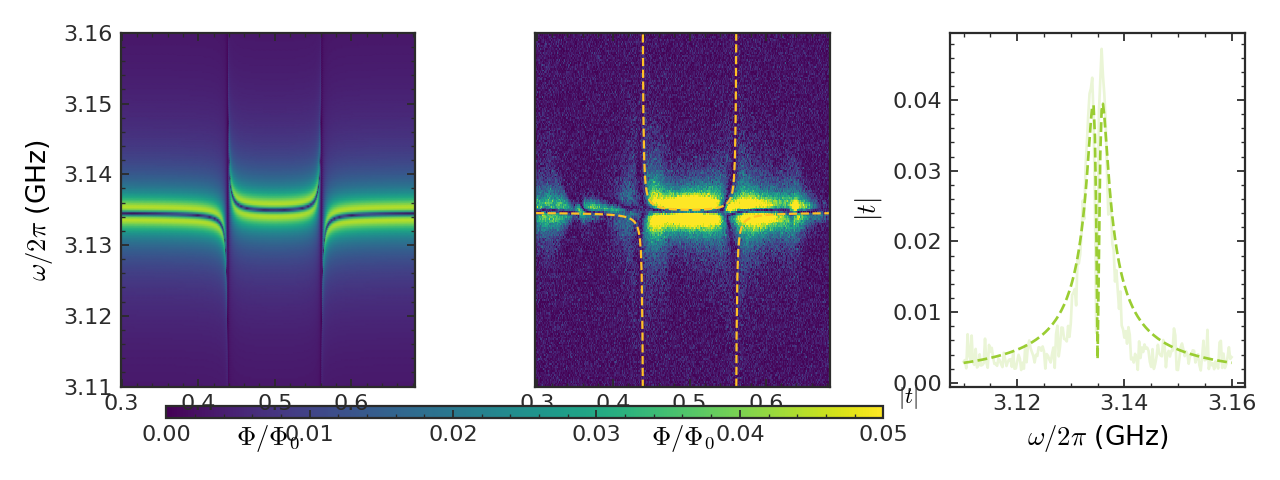

<ipython-input-465-42fbc31e73e1>:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [465]:
# Seed values. Remember - these are all g/2pi, Γ/2pi, k/2pi etc...

# Master equation simulation (MHz)
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ) * 1000  # to convert from GHz to MHz
deltaR = np.array(deltaR) * 1000

transmission_function = make_transmission_function(Gamma, 0, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))

# Plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 3, 2)
im1 = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z, shading="nearest", vmax=0.05, vmin=0, rasterized=True)
cbar_ax = fig.add_axes([0.13, 0.13, 0.56, 0.025])
cb = fig.colorbar(im1, cax=cbar_ax, orientation="horizontal")
cb.set_label("$|t|$", ha="left", x=1.02, fontsize=10, labelpad=-27)
ax.set_xlabel("$\Phi/\Phi_0$", fontsize=12)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
(e_low_plot,) = ax.plot(
    FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="--", linewidth=1
)
(e_high_plot,) = ax.plot(
    FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="--", linewidth=1
)

ax1 = fig.add_subplot(1, 3, 1)
im2 = ax1.pcolormesh(
    deltaXMesh, deltaYMesh, tMesh, shading="gouraud", vmax=0.2, vmin=0, rasterized=True
)
ax1.set_xlabel("$\Phi/\Phi_0$", fontsize=12)
ax1.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=12)
ax.set_yticks([])
ax.set_yticklabels([])
# ax1.axvline(data3d_x[SLICE_VERTICAL], color="C2")
# ax1.axhline(data3d_y[SLICE_HORIZONTAL], color=MY_COLOURS["DarkRed"])

# Raw data (scaled for losses and attenuation)
ax2 = fig.add_subplot(1, 3, 3)
ax2.plot(
    data3d_y,
    (data3d_z[:, SLICE_VERTICAL] - TRANSMISSION_OFFSET) / TRANSMISSION_MULTIPLIER,
    color="C2",
    alpha=0.2,
)
(slice_y_plot,) = ax2.plot(
    deltaYMesh[:, SLICE_VERTICAL],
    transmissionScalingPrefactor * tMesh[:, SLICE_VERTICAL],
    color="C2",
    linestyle="--",
)
ax2.set_xlabel("$\omega/2\pi$ (GHz)", fontsize=12)
ax2.set_ylabel("$|t|$", fontsize=12)
plt.tight_layout()

In [466]:
plt.savefig("./data/2020-07_cqps-single/quantitative-fit-m2-slice.svg")

### m=3

In [440]:
FILENAME = "./data/CQPS paper/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
if os.getenv("ILYAS_SIMULATIONS"):
    #     FILENAME="./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data.txt"
    FILENAME = "./data/2020-07_cqps-single/anticrossing/TiN95_CQPS_C_July12'20_mfield-5_12G_16_data-ilya-corrected.txt"
OFFSET = 1.4566 - PERIOD / 2

# Fitted parameters from before
resonator_f = 5.12  # GHz measured
kappa = 6.19  # MHz fitted in resonator. kappa/2pi
# kappa = 5.5  # MHz fitted in resonator. kappa/2pi
omega_drive = resonator_f * GHz * 2 * np.pi
C_k = C_per_unit_length * 20 * um  # From dimensions of coupling capacitor
transmissionScalingPrefactor = (
    1 / 2 * (C_k**2 * omega_drive**2 * Z) / C_resonator / MHz
)  # Needs to be in MHz, because make_transmission_function requires and returns a result in MHz units

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))

    first_line = fin.readline().split()
    data3d_x = np.linspace(
        float(first_line[1]), float(first_line[2]), data3d_z.shape[1]
    )
    data3d_x = (data3d_x - OFFSET) / PERIOD

    second_line = fin.readline().split()
    data3d_y = np.linspace(
        float(second_line[1]), float(second_line[2]), data3d_z.shape[0]
    )

# Build meshes and arrays based of the ranges in the file
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], len(data3d_x))
sweep_f = np.linspace(data3d_y[0], data3d_y[-1], len(data3d_y))
deltaXMesh, deltaYMesh = np.meshgrid(FLUX_NUMBER, sweep_f)

# Qubit (GHz)
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"]
)
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

#### Tuning

<IPython.core.display.Javascript object>


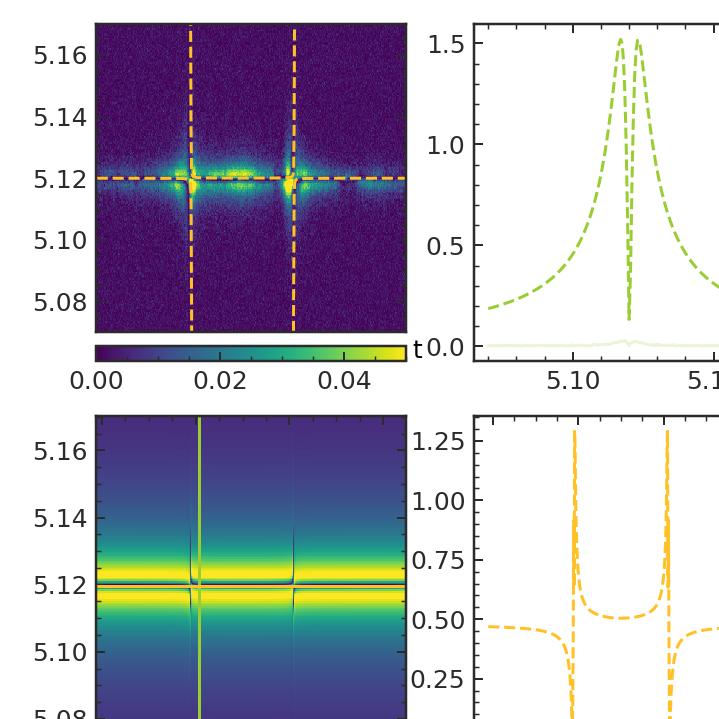

In [411]:
# Seed values. Remember - these are all g/2pi, Γ/2pi, k/2pi etc...
# g = 20
g = 9.95
Gamma = 14

SLICE_HORIZONTAL = 99
SLICE_VERTICAL = 199

ZMIN = 0
ZMAX = 0.05

ADDITIONAL_ATTENUATION = -0.5
TRANSMISSION_MULTIPLIER = 10 ** (
    (-30 - 60 + 35 + 28 + 28 - ADDITIONAL_ATTENUATION) / 10
)
TRANSMISSION_OFFSET = -0.003
# TRANSMISSION_OFFSET = -0.01

# Resonator-qubit spectrum (GHz)
(e_low, e_high) = qubit_resonator_spectrum(
    qubit_f01, resonator_f, g / 1000  # convert to GHz
)
# Master equation simulation (MHz)
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ) * 1000  # to convert from GHz to MHz
deltaR = np.array(deltaR) * 1000

transmission_function = make_transmission_function(Gamma, 0, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))

fig = plt.figure(figsize=(5, 5))

# Plot of raw data and Jaynes Cummings overlay
ax = fig.add_subplot(2, 2, 1)
im = ax.pcolormesh(
    data3d_xmesh, data3d_ymesh, data3d_z, shading="nearest", vmax=ZMAX, vmin=ZMIN
)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, orientation="horizontal")
cb.set_label("t", ha="left", x=1.02, fontsize=10, labelpad=-22)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.set_xticks([])
ax.set_xticklabels([])
(e_low_plot,) = ax.plot(FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="--")
(e_high_plot,) = ax.plot(
    FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="--"
)

# Plot of master equation simulation
ax1 = fig.add_subplot(2, 2, 3)
ax1.pcolormesh(deltaXMesh, deltaYMesh, tMesh, shading="nearest", 
               vmax=ZMAX, vmin=ZMIN
              )
ax1.axvline(data3d_x[SLICE_VERTICAL], color="C2")
ax1.axhline(data3d_y[SLICE_HORIZONTAL], color=MY_COLOURS["Orange"])

# Fitting cross section in field
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(
    data3d_y,
    (data3d_z[:, SLICE_VERTICAL] - TRANSMISSION_OFFSET) / TRANSMISSION_MULTIPLIER,
    color="C2",
    alpha=0.2,
)
(slice_y_plot,) = ax2.plot(
    deltaYMesh[:, SLICE_VERTICAL],
    +transmissionScalingPrefactor * tMesh[:, SLICE_VERTICAL],
    color="C2",
    linestyle="--",
)

# Fitting cross section in field
ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(
    data3d_x,
    (data3d_z[SLICE_HORIZONTAL, :] - TRANSMISSION_OFFSET) / TRANSMISSION_MULTIPLIER,
    color=MY_COLOURS["Orange"],
    alpha=0.2,
)
(slice_x_plot,) = ax3.plot(
    deltaXMesh[SLICE_HORIZONTAL, :],
    transmissionScalingPrefactor * tMesh[SLICE_HORIZONTAL, :],
    color=MY_COLOURS["Orange"],
    linestyle="--",
)
plt.tight_layout()

In [249]:
def update(g: float, Gamma: float, toggle: bool, kappa):
    e_low_plot.set_visible(toggle)
    e_high_plot.set_visible(toggle)
    if toggle:
        (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g / 1000)
        e_low_plot.set_ydata(e_low)
        e_high_plot.set_ydata(e_high)

    transmission_function = make_transmission_function(Gamma, 0, kappa, g)
    tMesh = np.transpose(transmission_function(deltaQ, deltaR))
    ax1.clear()
    ax1.pcolormesh(deltaXMesh, deltaYMesh, tMesh, shading="gouraud", vmin=ZMIN, vmax=ZMAX)
    slice_y_plot.set_ydata(transmissionScalingPrefactor * tMesh[:, SLICE_VERTICAL])
    slice_x_plot.set_ydata(transmissionScalingPrefactor * tMesh[SLICE_HORIZONTAL, :])


CONTINOUS_UPDATE = False
g_widget = ipywidgets.FloatSlider(
    min=0,
    max=200,
    step=0.05,
    description="$g/2\pi (MHz)$",
    value=g,
    layout=ipywidgets.Layout(width="90%"),
    continuous_update=CONTINOUS_UPDATE,
)
# resonator_widget = ipywidgets.FloatSlider(
#     min=resonator_f*0.9, max=resonator_f*1.1, step=0.005,
#     description="$f_r (GHz)$", value=resonator_f,
#     layout=ipywidgets.Layout(width='90%'),
#     continuous_update=CONTINOUS_UPDATE
# )
Gamma_widget = ipywidgets.FloatSlider(
    min=-100,
    max=50,
    step=0.1,
    description="$\Gamma/2\pi (MHz)$",
    value=Gamma,
    layout=ipywidgets.Layout(width="90%"),
    continuous_update=CONTINOUS_UPDATE,
)
kappa_widget = ipywidgets.FloatSlider(
    min=0,
    max=20,
    step=0.1,
    description="$\kappa/2\pi (MHz)$",
    value=kappa,
    layout=ipywidgets.Layout(width="90%"),
    continuous_update=CONTINOUS_UPDATE,
)
toggle_widget = ipywidgets.Checkbox(description="Show/Hide Fit", value=True)

ui = ipywidgets.GridspecLayout(4, 2)
# ui[0,:] = resonator_widget
ui[0, :] = g_widget
ui[1, :] = Gamma_widget
ui[2, :] = kappa_widget
ui[3, :] = toggle_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "g": g_widget,
        #         "resonator_f": resonator_widget,
        "toggle": toggle_widget,
        "Gamma": Gamma_widget,
        "kappa": kappa_widget,
    },
)

#### Final plot

<IPython.core.display.Javascript object>


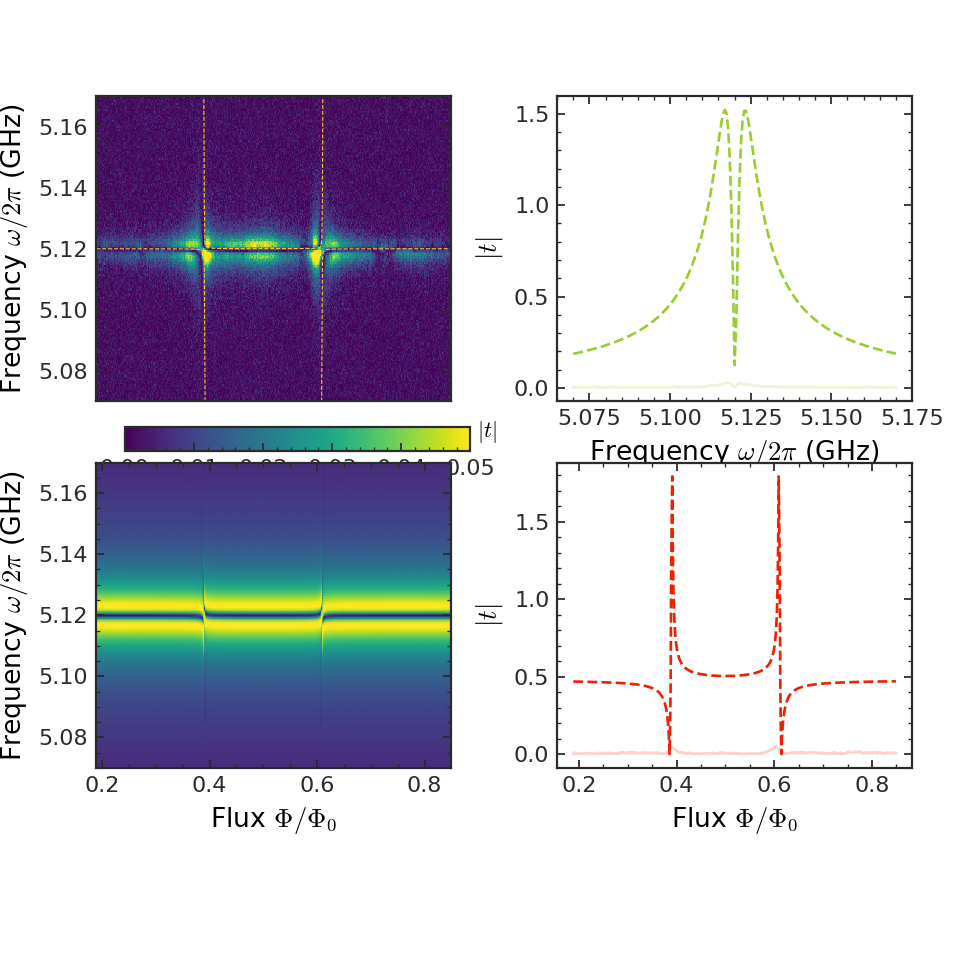

Text(0, 0.5, '$|t|$')

In [441]:
# Seed values. Remember - these are all g/2pi, Γ/2pi, k/2pi etc...
g = 9.95
Gamma = -14

SLICE_HORIZONTAL = 99
SLICE_VERTICAL = 200

ADDITIONAL_ATTENUATION = -0.5
TRANSMISSION_MULTIPLIER = 10 ** (
    (-30 - 60 + 35 + 28 + 28 - ADDITIONAL_ATTENUATION) / 10
)
TRANSMISSION_OFFSET = -0.003

# Resonator-qubit spectrum (GHz)
(e_low, e_high) = qubit_resonator_spectrum(
    qubit_f01, resonator_f, g / 1000  # convert to GHz
)
# Master equation simulation (MHz)
deltaQ = []
deltaR = []
for fq in qubit_f01:
    deltaQ.append(sweep_f - fq)
    deltaR.append(sweep_f - resonator_f)
deltaQ = np.array(deltaQ) * 1000  # to convert from GHz to MHz
deltaR = np.array(deltaR) * 1000

transmission_function = make_transmission_function(Gamma, 0, kappa, g)
tMesh = np.transpose(transmission_function(deltaQ, deltaR))

# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(2, 2, 1)
im1 = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z, shading="nearest", vmax=0.05, vmin=0, rasterized=True)
cbar_ax = fig.add_axes([0.13, 0.53, 0.36, 0.025])
cb = fig.colorbar(im1, cax=cbar_ax, orientation="horizontal")
cb.set_label("$|t|$", ha="left", x=1.02, fontsize=10, labelpad=-27)
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)", fontsize=12)
ax.set_ylim([data3d_y[0], data3d_y[-1]])
ax.set_xticks([])
ax.set_xticklabels([])
# ax.axvline(data3d_x[SLICE_VERTICAL], color="C2")
# ax.axhline(data3d_y[SLICE_HORIZONTAL], color=MY_COLOURS["DarkRed"])
(e_low_plot,) = ax.plot(
    FLUX_NUMBER, e_low, color=MY_COLOURS["Orange"], linestyle="--", linewidth=0.5
)
(e_high_plot,) = ax.plot(
    FLUX_NUMBER, e_high, color=MY_COLOURS["Orange"], linestyle="--", linewidth=0.5
)

ax1 = fig.add_subplot(2, 2, 3)
im2 = ax1.pcolormesh(
    deltaXMesh, deltaYMesh, tMesh, shading="gouraud", vmax=0.05, vmin=0, rasterized=True
)
ax1.set_xlabel("Flux $\Phi/\Phi_0$", fontsize=12)
ax1.set_ylabel("Frequency $\omega/2\pi$ (GHz)", fontsize=12)
# ax1.axvline(data3d_x[SLICE_VERTICAL], color="C2")
# ax1.axhline(data3d_y[SLICE_HORIZONTAL], color=MY_COLOURS["DarkRed"])

# Raw data (scaled for losses and attenuation)
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(
    data3d_y,
    (data3d_z[:, SLICE_VERTICAL] - TRANSMISSION_OFFSET) / TRANSMISSION_MULTIPLIER,
    color="C2",
    alpha=0.2,
)
(slice_y_plot,) = ax2.plot(
    deltaYMesh[:, SLICE_VERTICAL],
    transmissionScalingPrefactor * tMesh[:, SLICE_VERTICAL],
    color="C2",
    linestyle="--",
)
ax2.set_xlabel("Frequency $\omega/2\pi$ (GHz)", fontsize=12)
ax2.set_ylabel("$|t|$", fontsize=12)

# Raw data (scaled for losses and attenuation)
ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(
    data3d_x,
    (data3d_z[SLICE_HORIZONTAL, :] - TRANSMISSION_OFFSET) / TRANSMISSION_MULTIPLIER,
    color=MY_COLOURS["DarkRed"],
    alpha=0.2,
)
SUBSAMPLE = 1
(slice_x_plot,) = ax3.plot(
    # Subsample
    deltaXMesh[SLICE_HORIZONTAL, :][::SUBSAMPLE],
    transmissionScalingPrefactor * tMesh[SLICE_HORIZONTAL, :][::SUBSAMPLE],
    color=MY_COLOURS["DarkRed"],
    linestyle="--",
    #     marker="o"
)
ax3.set_xlabel("Flux $\Phi/\Phi_0$", fontsize=12)
ax3.set_ylabel("$|t|$", fontsize=12)
# plt.tight_layout()

In [308]:
im1.remove()
im2.remove()
plt.savefig("data/2020-07_cqps-single/qubit12_anticrossing_resonatorMode3.svg",dpi=100, transparent=True)

In [40]:
plt.savefig("data/2020-07_cqps-single/qubit12_anticrossing_resonatorMode3.png",dpi=300)

# Strong and weak coupling
\begin{equation}
 \Gamma_1, \Gamma_2, \kappa << g
\end{equation}

In [ ]:
# String reime when the characeristic energy higher than incoherent processes. Needed to manipualte quantum states and exchange information with system


# (Figure ?) Inductive vs Capacitive Coupling

Galvanical coupling of the qubit's persistent current $I_p$ and the resonator current $I_{res}$ via a shared inductance $L_s$. In the persistent current basis this is represented by

\begin{equation}
\hbar g = L_s I_{res} I_p \sigma_z
\end{equation}

where $g$ is the coupling rate.

Rotating into the qubit basis gives

\begin{equation}
H_{int} = \hbar g = L_s I_{res} I_p \bigg(\frac{E_s}{\hbar \omega_q}\sigma_x+\frac{2 I_p \Phi_0 (f- 1/2)}{\hbar \omega_q}\sigma_z\bigg).
\end{equation}

Under Rotating Wave Approximation (RWA) exact diagonalisation of the Jaynes-Cumming Hamiltonian results in the system ground state $|0,0>$ and dressed excited states

\begin{align}
|+, n> & = \cos \theta_n |1, n-1> + \sin \theta_n |0, n> \\ 
|-, n> & = \sin \theta_n |1, n-1> - \cos \theta_n |0, n>
\end{align}

with the mixing angle

\begin{equation}
\theta_n = \frac{1}{2} \arctan \bigg( \frac{2 g \sqrt{n+1}}{\omega_{rq}} \bigg)
\end{equation}

The corresponding eigenergies are

\begin{align}
E_{1,0} & = -\frac{\hbar}{2}\omega_{rq}, \\ 
E_{\pm,n} & = (n+1)\hbar\omega_r \pm \frac{\hbar}{2} \sqrt{4 g^2 (n+1) + \omega^2_{rq}}
\end{align}

It is obvious that the resonator-qubit detuning $\omega_{rq} = \omega_q -\omega_r$ is a crucial parameter of the system.

Reference: Sebastian Skacels' thesis (page 33)

In the flux eigenbasis, the inductive coupling can be expressed as $g_{\Phi}= \frac{L_s I_r I_p}{h}$. Transforming to the qubit frame, the coupling is given by:

\begin{align}
\frac{g}{h} & =\frac{g_{\Phi}}{h}\frac{E_s}{E_q}
\\ \frac{g}{h} & = L_s I_r I_p\frac{E_s}{E_q}
\\ \frac{g}{h} & = L_s I_r I_p\frac{E_s}{\sqrt{(2 I_p \delta\Phi)^2+E_s^2}}
\end{align}

Here, $E_s$ is the tunelling energy and $E_q$ is the flux-dependent qubit energy.

Inserting the resonator current

\begin{equation}
I_r = \sqrt{h f_r/ 2 L_r} \sin(kx)
\end{equation}

gives

\begin{equation}
 \frac{g}{h}= L_s I_p \sqrt{\frac{h f_r/ 2 L_r}{(2 I_p \delta\Phi / E_s)^2+1}}\sin(kx)
\end{equation}

More references:
- O. V. Astafiev, L. B. Ioffe, S. Kafanov, Y. A. Pashkin, K. Y. Arutyunov, D. Shahar, O. Cohen, and J. S. Tsai. “Coherent quantum phase slip”. In: Nature 484.7394 (2012), pp. 355–358. DOI: 10.1038/nature10930 (cit. on pp. 3, 36, 40, 91, 99, 101, 113, 130)

- G. Oelsner, S. H. W. van der Ploeg, P. Macha, U. Hübner, D. Born, S. An- ders, E. Il’ichev, H.-G. Meyer, M. Grajcar, S. Wünsch, M. Siegel, A. N. Omelyanchouk, and O. Astafiev. “Weak continuous monitoring of a flux qubit using coplanar waveguide resonator”. In: Phys. Rev. B 81 (17 2010), p. 172505. DOI: 10.1103/PhysRevB.81.172505 (cit. on pp. 101, 103).

- J. T. Peltonen, O. V. Astafiev, Y. P. Korneeva, B. M. Voronov, A. A. Ko- rneev, I. M. Charaev, A. V. Semenov, G. N. Golt’sman, L. B. Ioffe, T. M. Klapwijk, and J. S. Tsai. “Coherent flux tunneling through NbN nanowires”. In: Phys. Rev. B 88 (22 2013), p. 220506. DOI: 10.1103/PhysRevB. 88.220506 (cit. on pp. 3, 36, 43, 91, 93, 99, 101, 113).

\begin{equation}
I_r = \sqrt{h f_r/ 2 L_r}
\end{equation}

- T. Lindstrom, C. H. Webster, J. E. Healey, M. S. Colclough, C. M. Muir- head, and A. Ya. “Circuit QED with a flux qubit strongly coupled to a copla- nar transmission line resonator”. In: Superconductor Science and Technol- ogy 20.8 (2007), p. 814. DOI: 10.1088/0953-2048/20/8/016 (cit. on pp. 101, 103).(-> for $I_r$)


In comparison to capacitive coupling

\begin{equation}
   g = \frac{\pi E_S }{2 e}C_{q-r}\sqrt{\frac{\hbar \omega_p}{C_r}}\cos{(k x)} 
\end{equation}

<IPython.core.display.Javascript object>


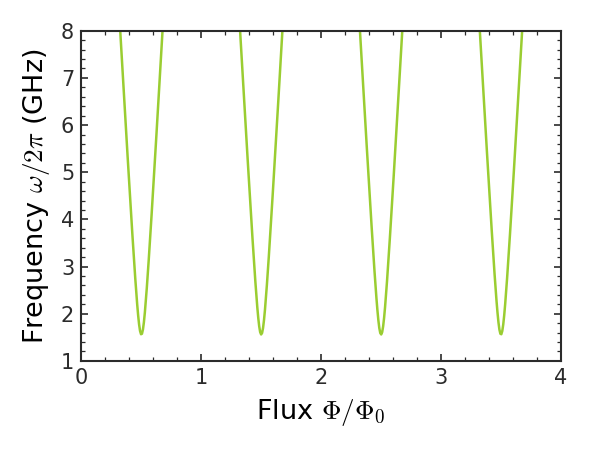

In [264]:
#Qubit Simulation
FLUX_NUMBER = np.linspace(0, 4, 500)
EL = 22.2 #GHz
ES = 1.56 #GHz

# Simulation
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(FLUX_NUMBER, qubit_f01, color=MY_COLOURS["Green"])
# ax.plot(field, response,
#         linestyle="", markersize=3,
#         marker="o", color="orange")
# ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
#               shading='nearest',
#               cmap=plt.cm.ocean)

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Frequency $\omega/2\pi$ (GHz)")
ax.set_ylim([1, 8])
ax.set_xlim([0, 4])
plt.tight_layout()

Lr = 1609.9046485674746 nH
Cr = 63.0 fF
Ir = 0.8038550856796562 nA
C_q-r = 2e-15 F
6.374590302585711e-27
352422049.95593905


<IPython.core.display.Javascript object>


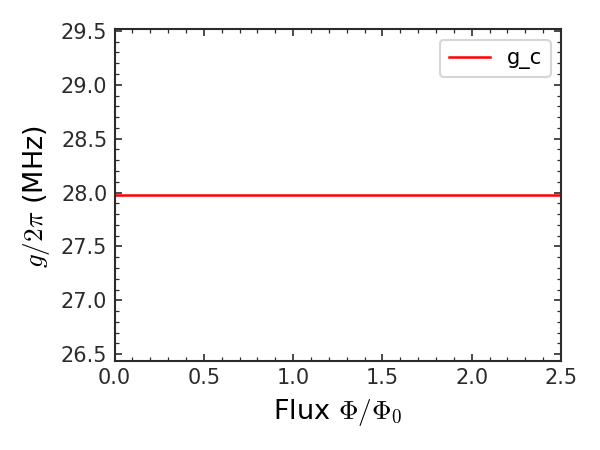

In [265]:
#Need to have run qubit simulation prior to this
import scipy.constants as c 

# ES = 3
#Choose parameters
Es = ES*GHz #Hz
# Ip = np.sqrt(abs((c.h*qubit_f01*1e9)**2-Es**2))/(2*FLUX_NUMBER/Phi0) #A #not sure about this
# fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# ax.plot(FLUX_NUMBER, Ip)
# ax.set_xlabel("Flux $\Phi/\Phi_0$")
# ax.set_ylabel("Ip (A) ")
# ax.set_xlim([0.5,10])

Ip = 7e-9 #A, persistent current (qubit 12)
#Ip = 10e-9 #A, persistent current
#Lr = 234e-9 #H, resonator inductance
fr = 3.14*GHz #Hz, resonator frequency
#Cr = 1/fr**2/Lr #F, resonator capacitance
Cr = 63e-15 #F, resonator capacitance
Lr = 1/fr**2/Cr #H, calculating resonator inductance
#fr_check = np.sqrt(1/(Lr*Cr))
#print('fr_check = ' + str(fr_check*1e-9) + ' GHz')
print('Lr = ' + str(Lr*1e9) + ' nH')
print('Cr = ' + str(Cr*1e15) + ' fF')
Ir = np.sqrt((c.h*fr)/(2*Lr)) #A, resonator current (typical value 2.47e-9)
print('Ir = ' + str(Ir*1e9) +' nA')

M = 100e-9 #H, mutual/shared inductance
Cqr = 2*fF #F, qubit-resonator coupling capacitance
print('C_q-r = '+str(Cqr) +' F')


#inductive coupling
g_l=(
    M*
    Ir*
    Ip*
     ES)/(qubit_f01) #Hz
print(g_l[1]/(2*c.pi))

#capacitive coupling
Vs = 2*np.pi*Es / 2 / e
Vr = np.sqrt(h * fr/Cr)
g_c = ((c.pi*Es)/(2*c.e))*Cqr*np.sqrt(c.h*fr/Cr) #Hz
# g_c = Vr * Vs * Cqr
print(gc)
# print('g_c/(2 pi) = '+str(g_c/(2*c.pi)*1e-6) + ' MHz')
#print('g_c = '+str(g_c*1e-6) + ' MHz')
# g_c_array = g_c/(2*c.pi)*np.ones(500)

#Plot g vs detuning
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# ax.plot(FLUX_NUMBER, g_l*1e-6,label='g_l', color ='b')
ax.plot(FLUX_NUMBER, g_c_array*1e-6,label='g_c', color ='r')
ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("$g/2\pi$ (MHz) ")
ax.set_xlim([0,2.5])
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


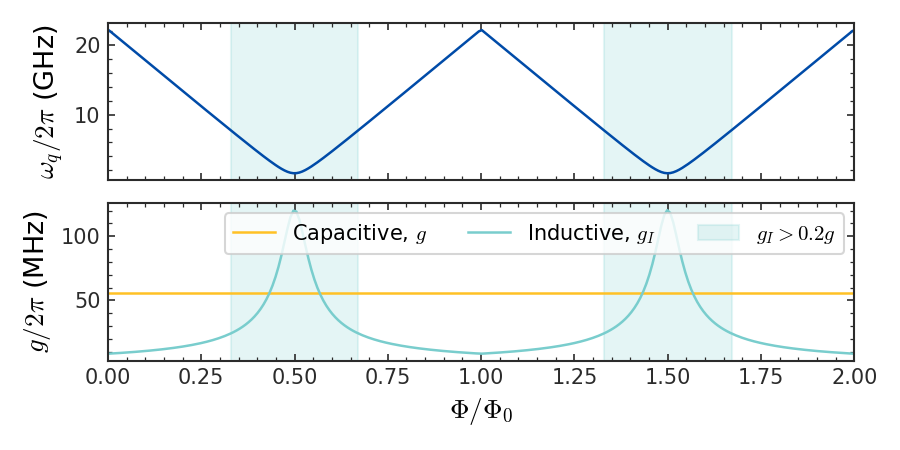

In [299]:
ES = 1.56 # already in frequency units - so result is also in freq units

C_qr = 2*fF
C_r = 63*fF
fr = 3.14*GHz
Vs = TWOPI * (ES*GHz) / (2 * e)
Vr = np.sqrt(h*fr / C_r)
gc = Vr * Vs * C_qr
gc_plot = gc / MHz / TWOPI # to convert to linear units normalise by 2pi

Ip = 7*nA # Measured
# Phi0 / (100*2*nH)
Lr = 1/fr**2/Cr # speed is 1/sqrt(LC) so speed is 
Lr = 1600*nH
Ir = np.sqrt(h*fr / Lr)
M = 10*nH # of the order

gi = M * Ir * Ip * ES / qubit_f01
gi_plot = gi / h / MHz

# Weal region
val = 0
gi_weak = max(gi_plot) * 0.2
for idx, x in enumerate(gi_plot):
    if (x > gi_weak):
        val = FLUX_NUMBER[idx]
        break        
        
fig, axr = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
ax = axr[0]
ax.plot(FLUX_NUMBER, qubit_f01, color="C0")
ax.set_ylabel("$\omega_q/2\pi$ (GHz)")
ax.axvspan(val,1-val, color="C4", alpha=0.2)
ax.axvspan(1+val,2-val, color="C4", alpha=0.2)

ax = axr[1]
ax.axvspan(val,1-val, color="C4", alpha=0.2)
ax.axvspan(1+val,2-val, color="C4", alpha=0.2, label="$g_I>0.2g$")
ax.plot(FLUX_NUMBER, gc_plot*np.ones(len(FLUX_NUMBER)), color ="C3", label="Capacitive, $g$")
ax.plot(FLUX_NUMBER, gi_plot, color ="C4", label="Inductive, $g_I$")
ax.set_xlabel("$\Phi/\Phi_0$")
ax.set_ylabel("$g/2\pi$ (MHz)")

ax.set_xlim([0,2])
# plt.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.5, 1.05),
# #           ncol=3, 
# #     fancybox=True, shadow=True
# )
ax.legend(
#     loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, 
#           shadow=True, 
          ncol=3
)

plt.tight_layout()
plt.savefig("./output/inductive-capacitive-coupling.svg")

In [38]:
g_c

677734711.4537289

In [35]:
Vr

5.752790903083752e-06

In [31]:
Vs

18849555921.538757

In [27]:
g_c

338051835.0044534

In [137]:
print(Cr*1e+15)

1733.7434676880496


# (Figure 6) Resistance 

<IPython.core.display.Javascript object>


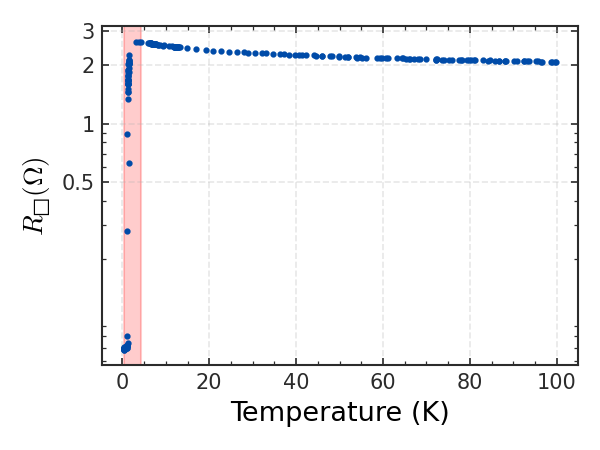

In [96]:
FILENAME = "./data/2020-07_cqps-single/resistance/TiN95_CQPS_DC_Apr12'19_Tdep_extract.txt"
data = np.loadtxt(FILENAME)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# ax.plot(data[250:, 0], np.log(data[250:, 1]), linestyle = "", marker="o")
ax.plot(data[250:, 0], data[250:, 1]/1000, linestyle = "", marker="o")
ax.axvspan(data[388,0], data[-1,0], color='red', alpha=0.2)
ax.set_ylabel("$R_{□} (\Omega)$")
ax.set_xlabel("Temperature (K)")
ax.set_yscale("log")
ax.set_yticks([0.5, 1, 2, 3])
ax.set_yticklabels([0.5, 1, 2, 3])
ax.grid(True)

plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", ".pdf"))

<IPython.core.display.Javascript object>


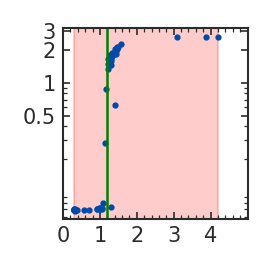

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
ax.plot(data[388:, 0], data[388:, 1]/1000, linestyle = "", marker="o")
# ax.set_ylabel("$R_{□} (\Omega)$")
# ax.set_xlabel("Temperature (K)")
plt.tight_layout()
plt.xticks(np.arange(0, 5, 1))
ax.axvline(1.2, color = 'green')
# ax.axvspan(data[388,0], np.log(data[-1,0]), color='red', alpha=0.2)
ax.axvspan(data[388,0], data[-1,0], color='red', alpha=0.2)
ax.set_xlim([-0, 5])
ax.set_yscale("log")
ax.set_yticks([0.5, 1, 2, 3])
ax.set_yticklabels([0.5, 1, 2, 3])
plt.tight_layout()

# plt.savefig(FILENAME.replace(".txt", "_insert.pdf"))

# (Figure 7) Multi Photon Process
- Tt cell

In [261]:
PERIOD = (1.084 - 0.485) / 3
FILENAME="./data/2020-07_cqps-single/multi-photon/TiN95_CQPS_C_July24'20_Tt_two_tone_03_data.txt"
# FILENAME="./data/CQPS paper/TiN95_CQPS_C_July24'20_Tt_two_tone_03_data.txt"
OFFSET = 5.423 - 5.5

# Load 3d data
with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1]) * mf_c
#     data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
    
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)
FLUX_NUMBER = np.linspace(data3d_x[0], data3d_x[-1], 200)

<IPython.core.display.Javascript object>


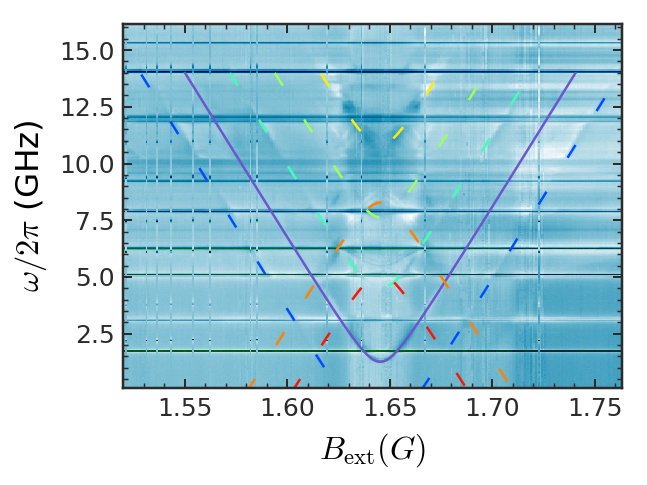

In [374]:
FLUX_NUMBER = np.linspace(5, 6, 500)
EL = 22.2
ES = 1.26

N_plots = 8
cmap = plt.cm.jet(np.linspace(0.2, 1, N_plots))
# cmap = ["C3", "C5", "C6", "C7", "C8", "C9"]
resonator_f = 3.18

# Simulation
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)
simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
qubit_f01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# We "can" look at the combined qubit-resonator system. But because we are NOT interested in the anticrossing features
# we can forget about the coupling and just write energy as sum of qubit and resonator energies
# (e_low, e_high) = qubit_resonator_spectrum(qubit_f01, resonator_f, g, N=0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

FLUX_NUMBER = mf_c * FLUX_NUMBER * PERIOD - 0.024
STYLE = {'linewidth':1, 'linestyle':"--", 'dashes':(6, 16)}

col_idx = 0
val = qubit_f01 - resonator_f
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color=cmap[col_idx], **STYLE); col_idx += 1
val = qubit_f01
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color="C5", linewidth=1); col_idx += 1
val = qubit_f01 + resonator_f
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color=cmap[col_idx], **STYLE); col_idx += 1
val = qubit_f01 + resonator_f*2
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color=cmap[col_idx], **STYLE); col_idx += 1
val = qubit_f01 + resonator_f *3
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color=cmap[col_idx], **STYLE); col_idx += 1
val = -qubit_f01 + 3*resonator_f
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color=cmap[col_idx], **STYLE); col_idx += 1
val = -qubit_f01 + 2*resonator_f
rfilter = val<14
simulation_graph, = ax.plot(FLUX_NUMBER[rfilter], val[rfilter], color=cmap[col_idx], **STYLE); col_idx += 1
# simulation_graph, = ax.plot(FLUX_NUMBER, -qubit_f01 + 1*resonator_f, color=cmap[col_idx], linewidth=2, alpha=0.4); col_idx += 1

im = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=plt.cm.ocean,
                   rasterized=True
#                    vmin=-0.5,
#                    vmax=0.2
             )
# cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="arg($t$)")

ax.set_xlabel("$B_\mathrm{ext} (G)$")
ax.set_ylabel("$\omega/2\pi$ (GHz)")
ax.set_ylim([min(data3d_y), max(data3d_y)])
ax.set_xlim([min(data3d_x), max(data3d_x)])
plt.tight_layout()

In [375]:
plt.savefig(FILENAME.replace(".txt", ".svg"))

# Estimating $E_s$ values
There are a range of different ways to evaluate the $E_c$ value.

In [65]:
# Measured during cooldown TiN95_CQPS_DC_Apr12'19_Tdep_extract.vi on a 80x20µm bar
R_square = 2.04*kOhm / 4
Tc_TiN = 1.2

# Derived
Delta = 1.784*kb*Tc_TiN
L_square = hbar * R_square / np.pi / Delta # Kinetic inductance

# Knowing the frequency of the resonator, we can approximate it's capacitance per square (resonator width is 5µm):
f_resonator = 3.14*GHz / 2 # As this is the second mode
C_square = 1/f_resonator**2/L_square

print(f"""
L_square = {L_square/nH:.2f}nH
C_square (5µm) = {C_square/nF:.2f}nF
""")


L_square = 0.58nH
C_square (5µm) = 0.70nF



## Sebastien de Graff and Sebastien Skatcel
 \begin{equation}
     \begin{aligned}
      E_s & = \Delta \sqrt{\frac{L}{\xi}}\frac{R_{Q}}{R_\xi} \text{exp}\left(-a\frac{R_{Q}}{R_\xi}\right) \\
      a & \approx 0.36 \\
      R_\xi & \text{ normal state resistance of wire segment of length } \xi\\
      R_{Q} & = \frac{h}{4e^{2}} \\
     \end{aligned}
 \end{equation}

In [238]:
# Sebastien paper: 2018_degraf_charge-control-of-blockade-of-cooper-pair-tunnelling-in-highly-disordered-TiN-nanowires-in-an-inductive-environment.pdf
# Also used titanium Nitride
a = 0.36

# All length units in nm
width = 10
L = 50 #nm
coherence_length = 4 #nm from 2018_degraf_charge-control-of-blockade-of-cooper-pair-tunnelling-in-highly-disordered-TiN-nanowires-in-an-inductive-environment.pdf
R_coherence_length = R_square * (coherence_length/width)

Es = Delta * np.sqrt(L/coherence_length) * Rq / R_coherence_length * np.exp(-a * Rq / R_coherence_length)

print(f"Es = {Es/ hbar / GHz:.4f}GHz")

Es = 0.3369GHz
